# 라이브러리

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks as cf
import plotly.express as px
import matplotlib_inline.backend_inline
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,StratifiedKFold,KFold,cross_val_score,GridSearchCV,learning_curve
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_auc_score,auc,roc_curve,precision_recall_curve,f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import shap

matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
plt.rc('font',family='AppleGothic')
plt.rc('axes',unicode_minus=False)
cf.go_offline(connected=True)

# 데이터 불러오기

In [102]:
data = pd.read_csv('data/Social_Network_Ads.csv')
data

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


# EDA

### head

In [103]:
data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


### tail

In [104]:
data.tail()

,User ID,Gender,Age,EstimatedSalary,Purchased
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0
399,15594041,Female,49,36000,1


In [105]:
data.shape

(400, 5)

### info

In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


### 결측치 확인

In [107]:
data.isnull().sum()

User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

### describe

In [108]:
data.describe().round()

,User ID,Age,EstimatedSalary,Purchased
count,400.0,400.0,400.0,400.0
mean,15691540.0,38.0,69742.0,0.0
std,71658.0,10.0,34097.0,0.0
min,15566689.0,18.0,15000.0,0.0
25%,15626764.0,30.0,43000.0,0.0
50%,15694342.0,37.0,70000.0,0.0
75%,15750363.0,46.0,88000.0,1.0
max,15815236.0,60.0,150000.0,1.0


### corr

<Axes: >

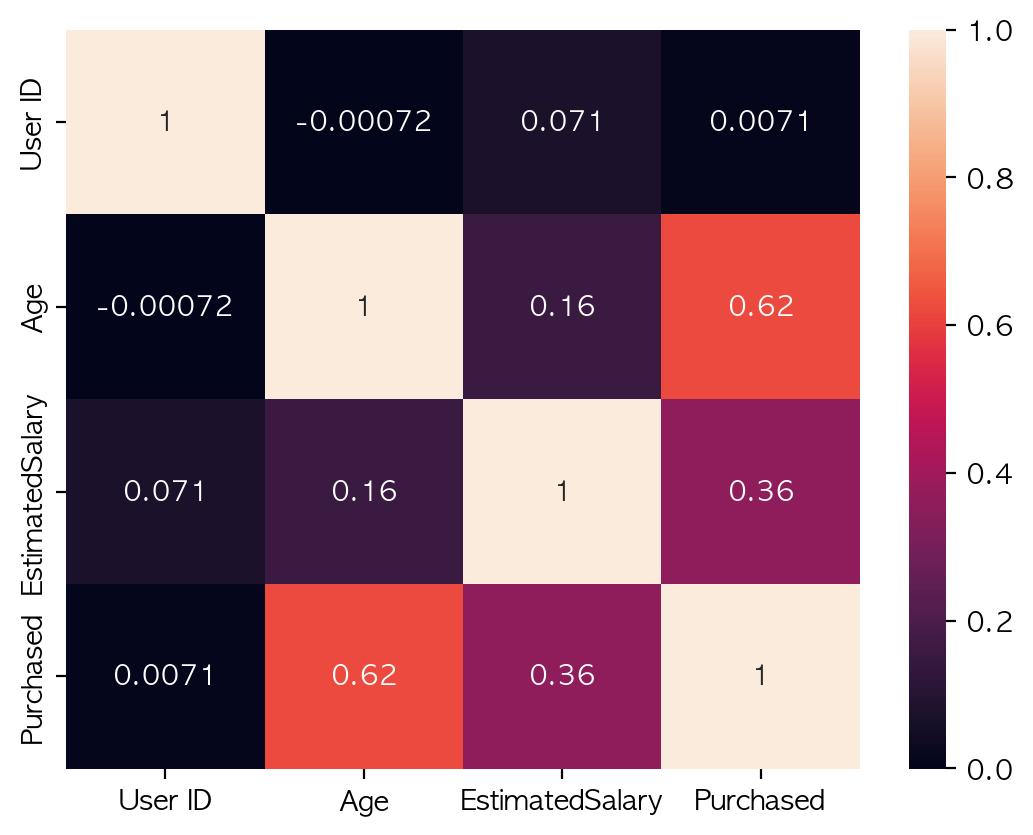

In [109]:
sns.heatmap(data.corr(numeric_only=True),annot=True)

### 구매에 특성 파악을 위한 함수 생성

In [110]:
def create_dataframe_purchased_rate(feature):
    # Purchased 가 1인 행의 특정 특징의 값에 따른 갯수
    purchased = data[data['Purchased']==1][feature].value_counts()
    
    # Purchased 가 0인 행의 특정 특징의 값에 따른 개수
    not_purchased = data[data['Purchased']==0][feature].value_counts()
    
    df_graph = pd.DataFrame([purchased,not_purchased])
    df_graph.index = ['Purchased','Not Purchased']
    
    return df_graph

### User ID 특성
- 고유값

In [111]:
data['User ID'].value_counts()

User ID
15624510    1
15767681    1
15589449    1
15791373    1
15688172    1
           ..
15675185    1
15792102    1
15722758    1
15745232    1
15594041    1
Name: count, Length: 400, dtype: int64

In [112]:
data['User ID'].nunique()

400

### Gender 특성

- Male,Femal 로 되어있다.
- Male : 0, Female : 1 로 맵핑

In [113]:
data['Gender'].value_counts()

Gender
Female    204
Male      196
Name: count, dtype: int64

#### gender 시각화

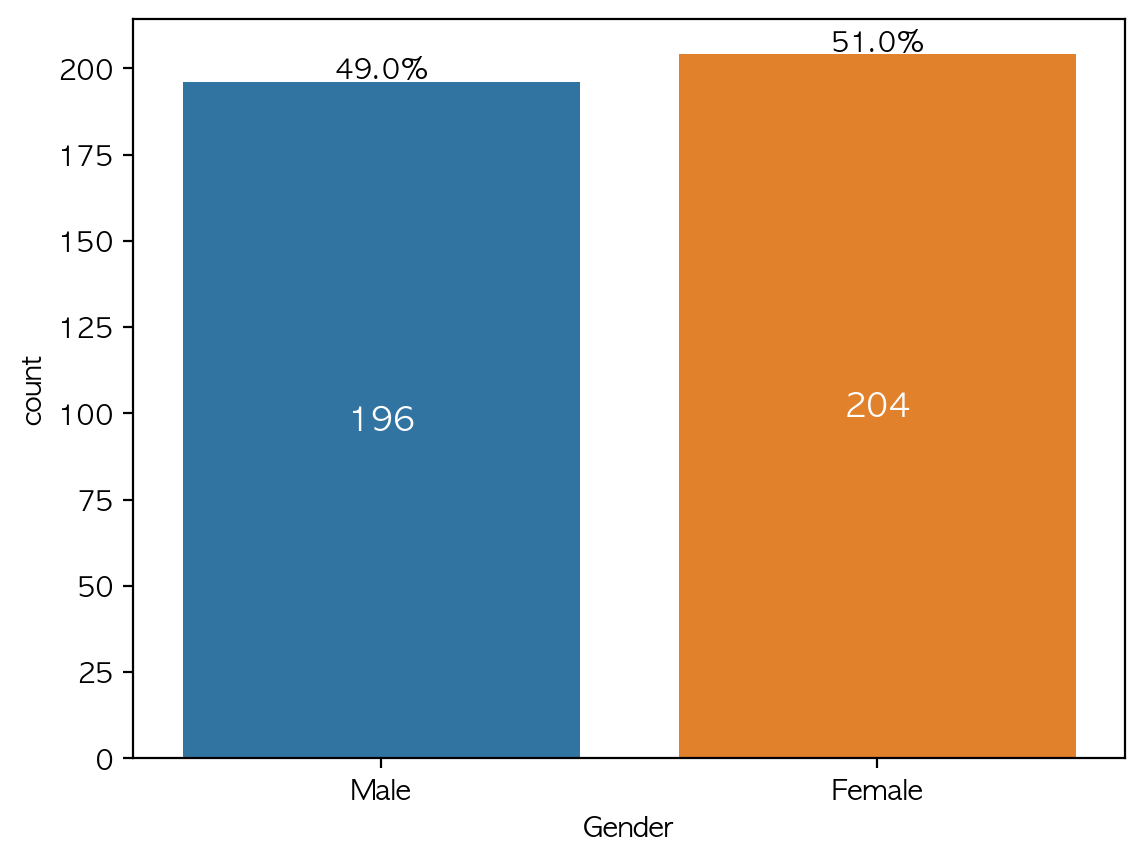

In [114]:

sns.countplot(
    data=data,
    x='Gender',
    hue='Gender'
)

total = len(data)  # 전체 데이터 개수
for p in plt.gca().patches:
    height = p.get_height()
    # 비율 계산
    percentage = f'{height/total*100:.1f}%'
    
    # 카운트를 막대의 가운데에 표시
    plt.gca().text(
        p.get_x() + p.get_width() / 2.,
        height / 2,  # 카운트가 막대의 중간에 표시되도록 위치 조정
        f'{int(height)}',  # 카운트만 표시
        ha="center", va='center', color='white', fontsize=12
    )
    
    # 비율을 막대 위에 표시
    plt.gca().text(
        p.get_x() + p.get_width() / 2.,
        height + 1,  # 텍스트가 막대 위에 표시되도록 위치 조정
        f'{percentage}',  # 비율만 표시
        ha="center", color='black', fontsize=10
    )
    
plt.show()

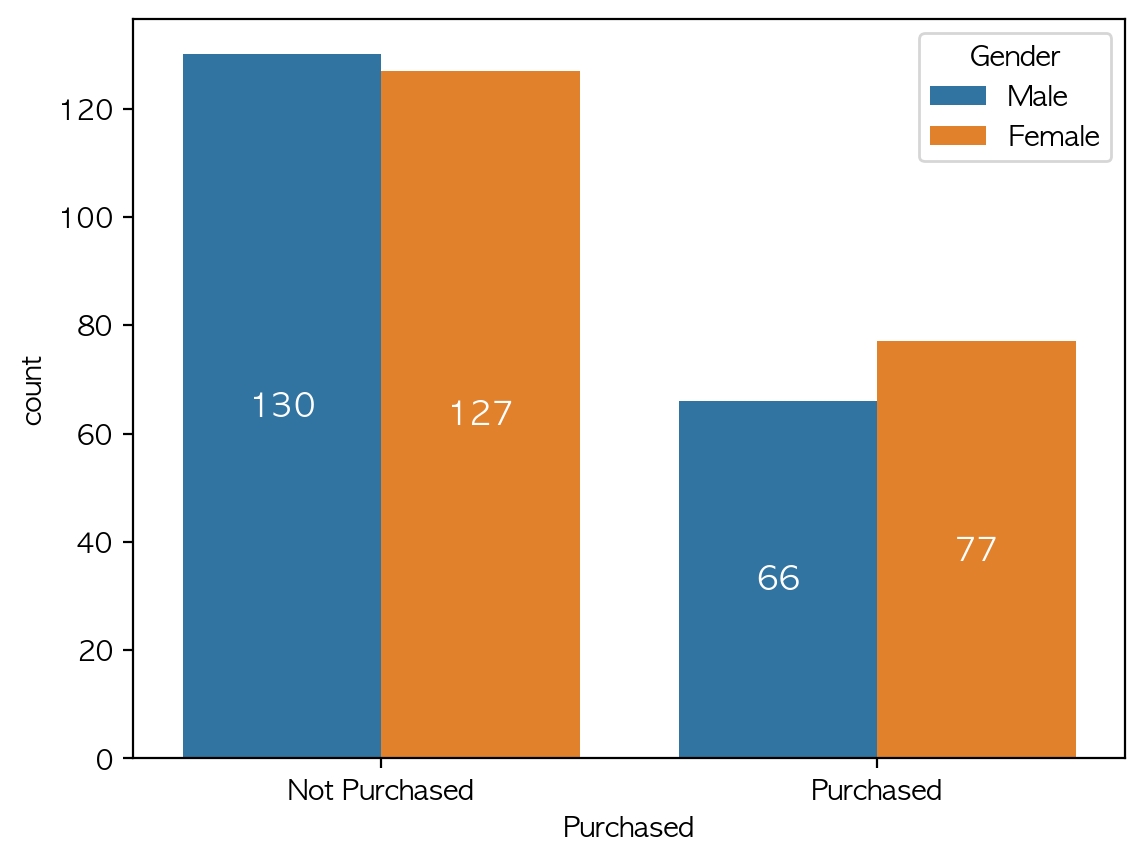

In [115]:
# countplot 생성
sns.countplot(
    data=data,
    x='Purchased',
    hue='Gender',
)

# 'Purchased' 상태별로 총 개수를 계산 (성별 구분 없이)
total_counts = data.groupby(['Purchased', 'Gender']).size().unstack()

# 전체 Purchased 상태별로 총 개수 계산 (성별 구분 없이)
total_by_purchased = data.groupby('Purchased').size()

# 비율과 카운트 표시
for p in plt.gca().patches:
    height = p.get_height()
    width = p.get_width()
    
    if width > 0:  # width가 0이 아닌 경우에만 계산 수행
        x = p.get_x() + width / 2

        # 현재 막대가 속하는 Purchased 상태와 Gender 계산
        purchased_status = int(p.get_x() / (2 * width))  # Purchased 상태를 0, 1로 구분
        gender = int(p.get_x() / width) % 2  # 0: 첫 번째 막대 (예: Male), 1: 두 번째 막대 (예: Female)

        # 비율 계산 (해당 Purchased 상태 내에서의 성별 비율)
        total = total_by_purchased[purchased_status]  # 해당 Purchased 상태의 전체 개수
        percentage = f'{height / total * 100:.1f}%'

        # 카운트를 막대 중앙에 표시
        plt.gca().text(x, height / 2, f'{int(height)}', ha='center', va='center', color='white', fontsize=12)

        # 비율을 막대 위에 표시
        # plt.gca().text(x, height + 1, percentage, ha='center', color='black', fontsize=10)

# x축 레이블을 '0', '1'에서 'Not Purchased', 'Purchased'로 변경
plt.xticks([0, 1], ['Not Purchased', 'Purchased'])

plt.show()

/var/folders/dn/kpsvhr056zz6gvcnmgrkklzr0000gn/T/ipykernel_87311/1047498555.py:1: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.




<Axes: xlabel='Gender', ylabel='Purchased'>

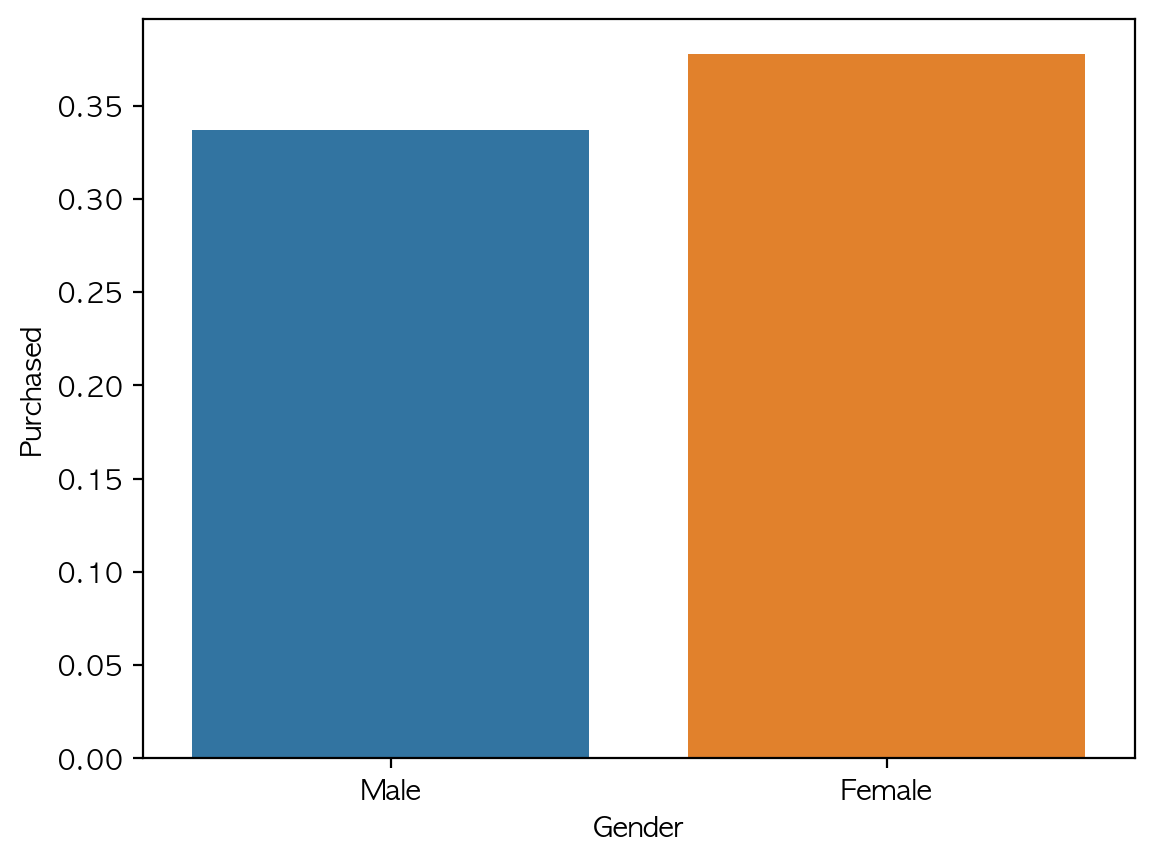

In [116]:
sns.barplot(
    data,
    x='Gender',
    y='Purchased',
    ci=False,
    hue='Gender',
)

/var/folders/dn/kpsvhr056zz6gvcnmgrkklzr0000gn/T/ipykernel_87311/2639110723.py:1: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.




<Axes: xlabel='Gender', ylabel='EstimatedSalary'>

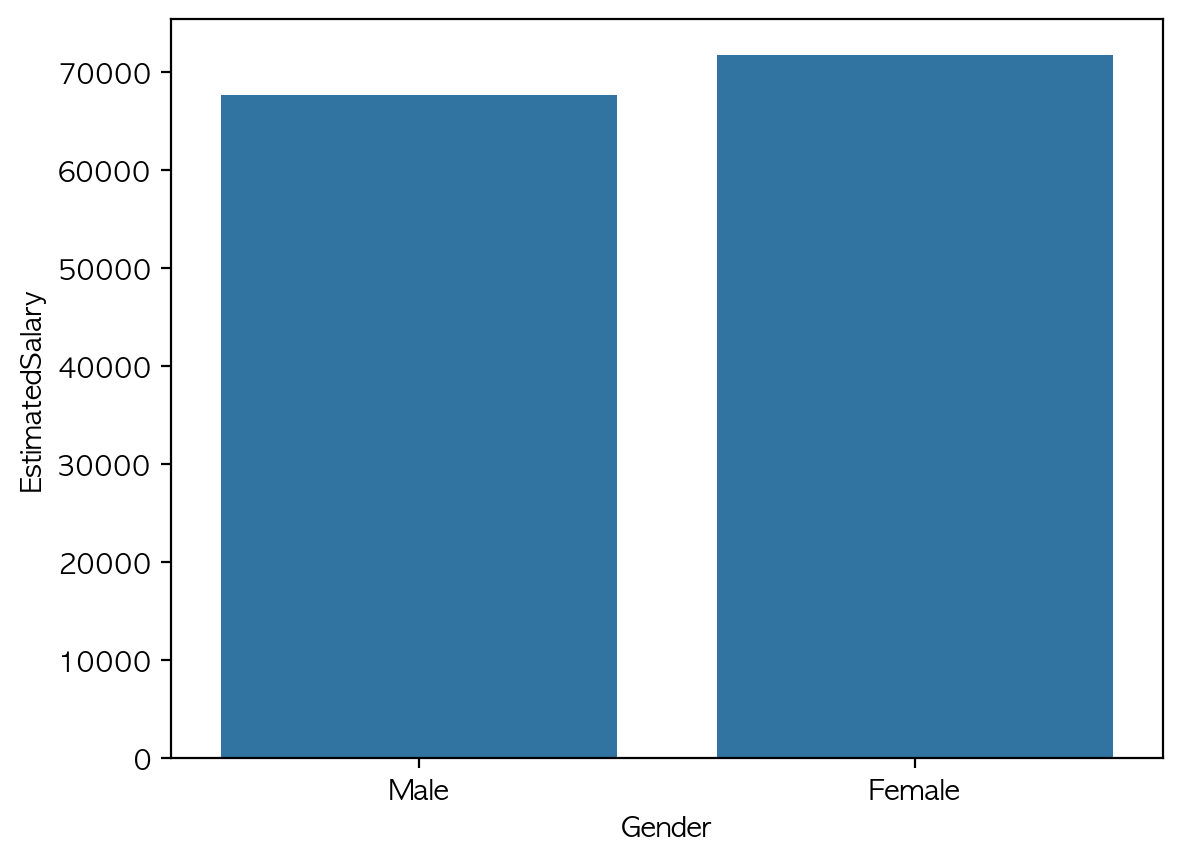

In [117]:
sns.barplot(
    data,
    x='Gender',
    y='EstimatedSalary',
    ci=False
)

### Age 특성
- min : 18
- max : 60
- mean : 37

In [118]:
print(sorted(data['Age'].unique()))
print(data['Age'].describe())


[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
count    400.000000
mean      37.655000
std       10.482877
min       18.000000
25%       29.750000
50%       37.000000
75%       46.000000
max       60.000000
Name: Age, dtype: float64


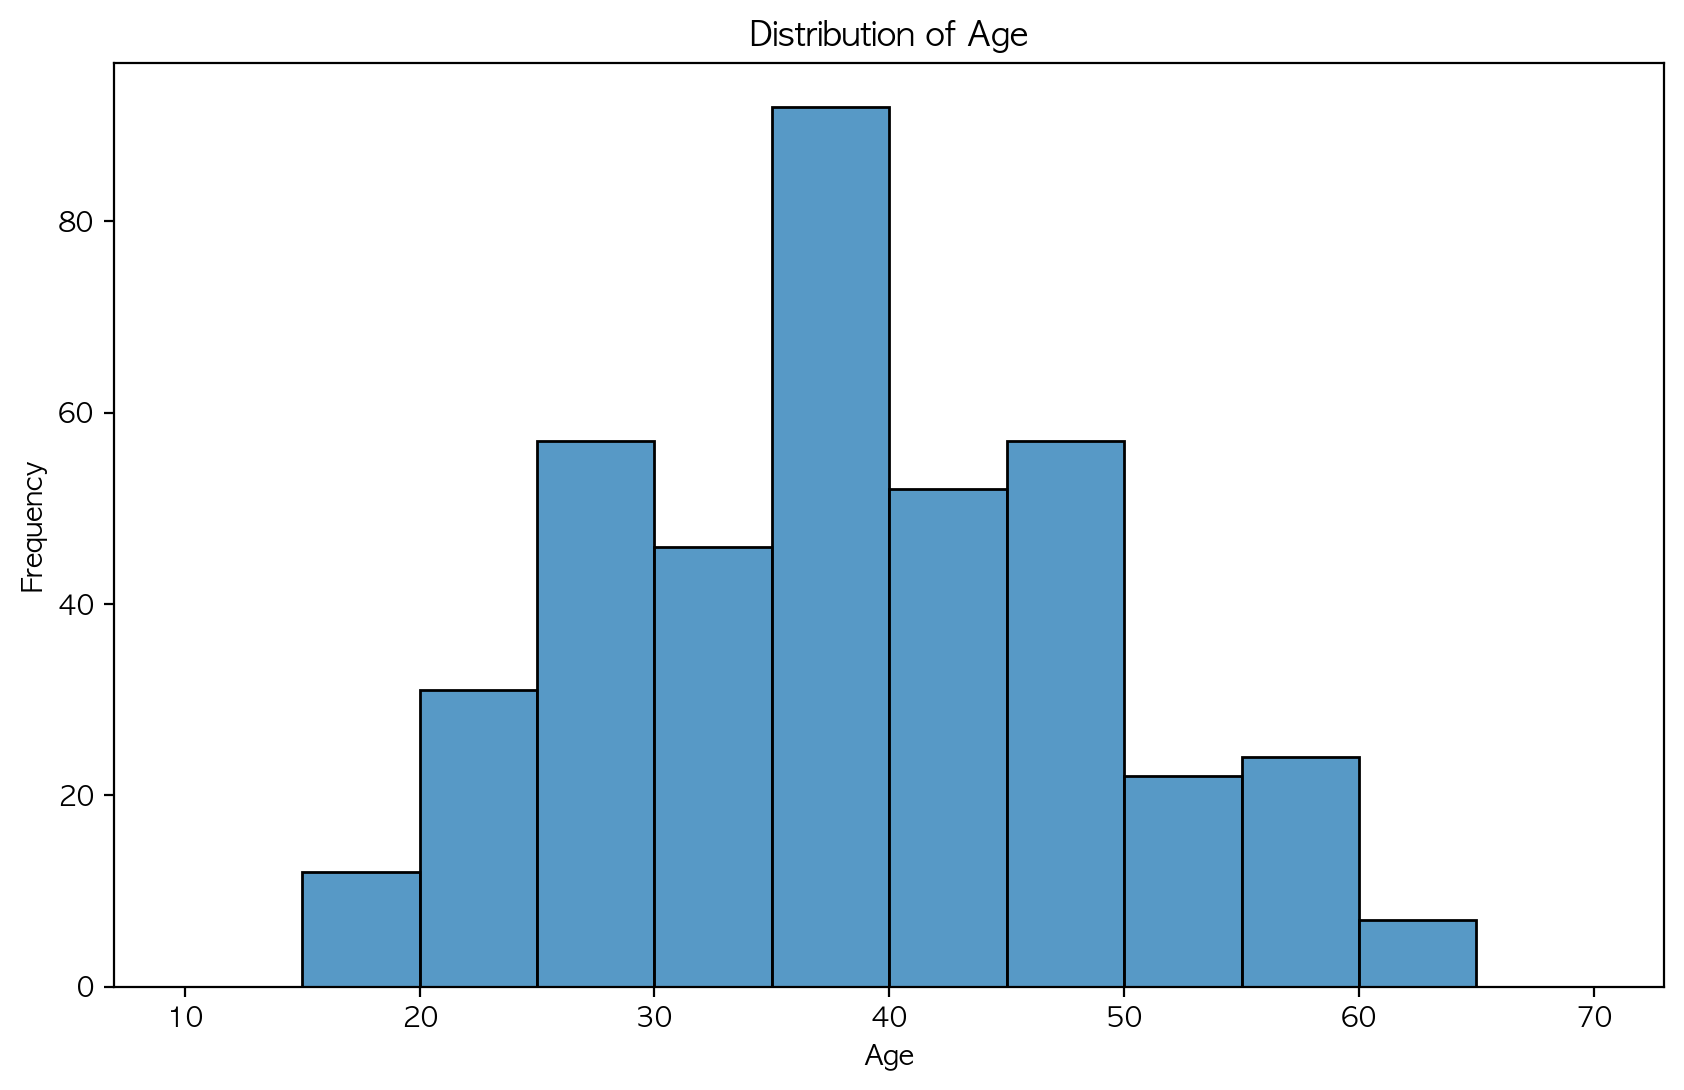

In [119]:
plt.figure(figsize=(10,6))
# 히스토그램 생성 (연령대별로 나누기 위해 수동으로 bins 설정)
# 히스토그램 생성
sns.histplot(
    data=data,
    x='Age',
    bins=np.arange(10, 75, 5),  # 5부터 75까지 10 간격으로 bins 설정
)

# x축 눈금을 10, 20, 30, 40, 50, 60, 70에 위치시키기
plt.xticks(np.arange(10, 71, 10))

# 그래프 제목 추가
plt.title("Distribution of Age")

# x축 레이블 추가
plt.xlabel("Age")

# y축 레이블 추가
plt.ylabel("Frequency")

# 그래프 표시
plt.show()

<Axes: xlabel='EstimatedSalary', ylabel='Age'>

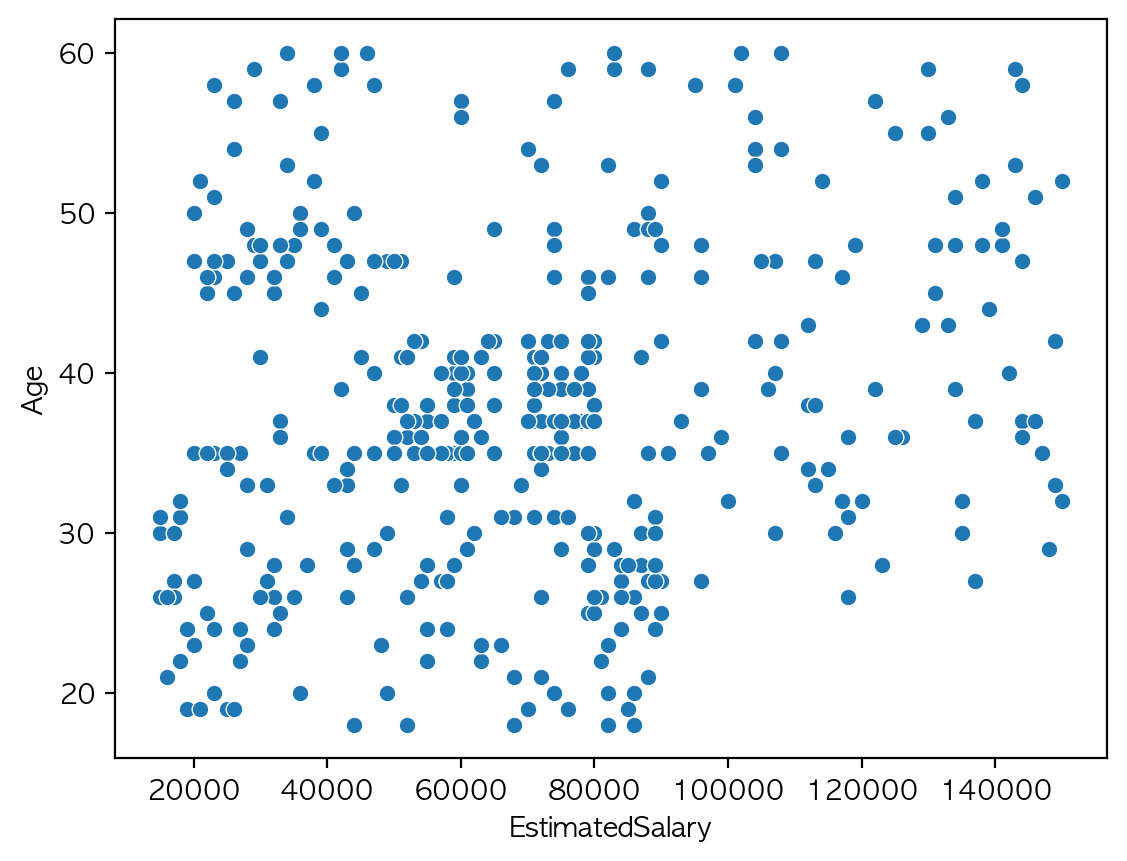

In [120]:
sns.scatterplot(
    data,
    y='Age',
    x='EstimatedSalary'
)

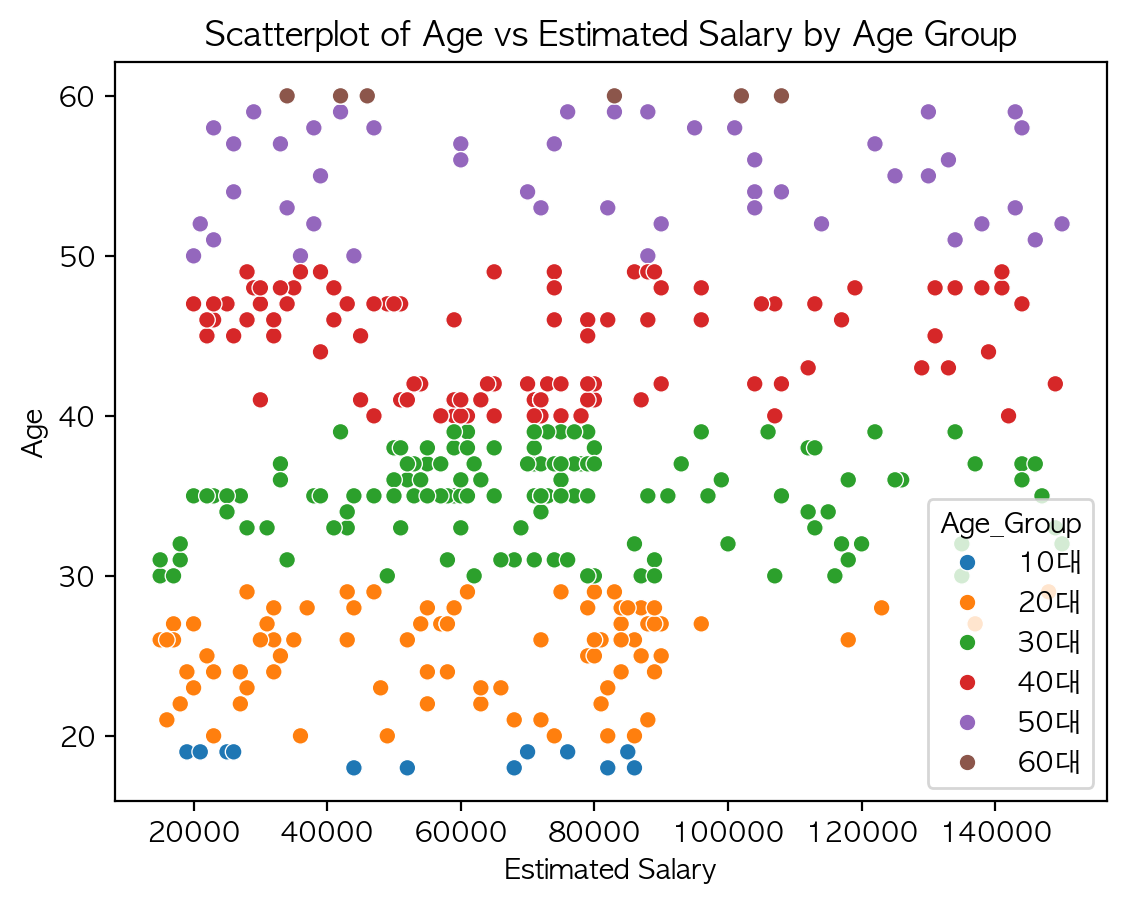

In [121]:
# 나이대 구분을 위한 범주 생성
bins = [10, 20, 30, 40, 50, 60, 70]  # 연령대 경계 값
labels = ['10대', '20대', '30대', '40대', '50대', '60대']  # 각 구간의 레이블
data['Age_Group'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

# scatterplot 생성
sns.scatterplot(
    data=data,
    y='Age',
    x='EstimatedSalary',
    hue='Age_Group',
)

# 그래프 제목과 축 레이블 추가 (optional)
plt.title("Scatterplot of Age vs Estimated Salary by Age Group")
plt.xlabel("Estimated Salary")
plt.ylabel("Age")

plt.show()

/var/folders/dn/kpsvhr056zz6gvcnmgrkklzr0000gn/T/ipykernel_87311/3562866912.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



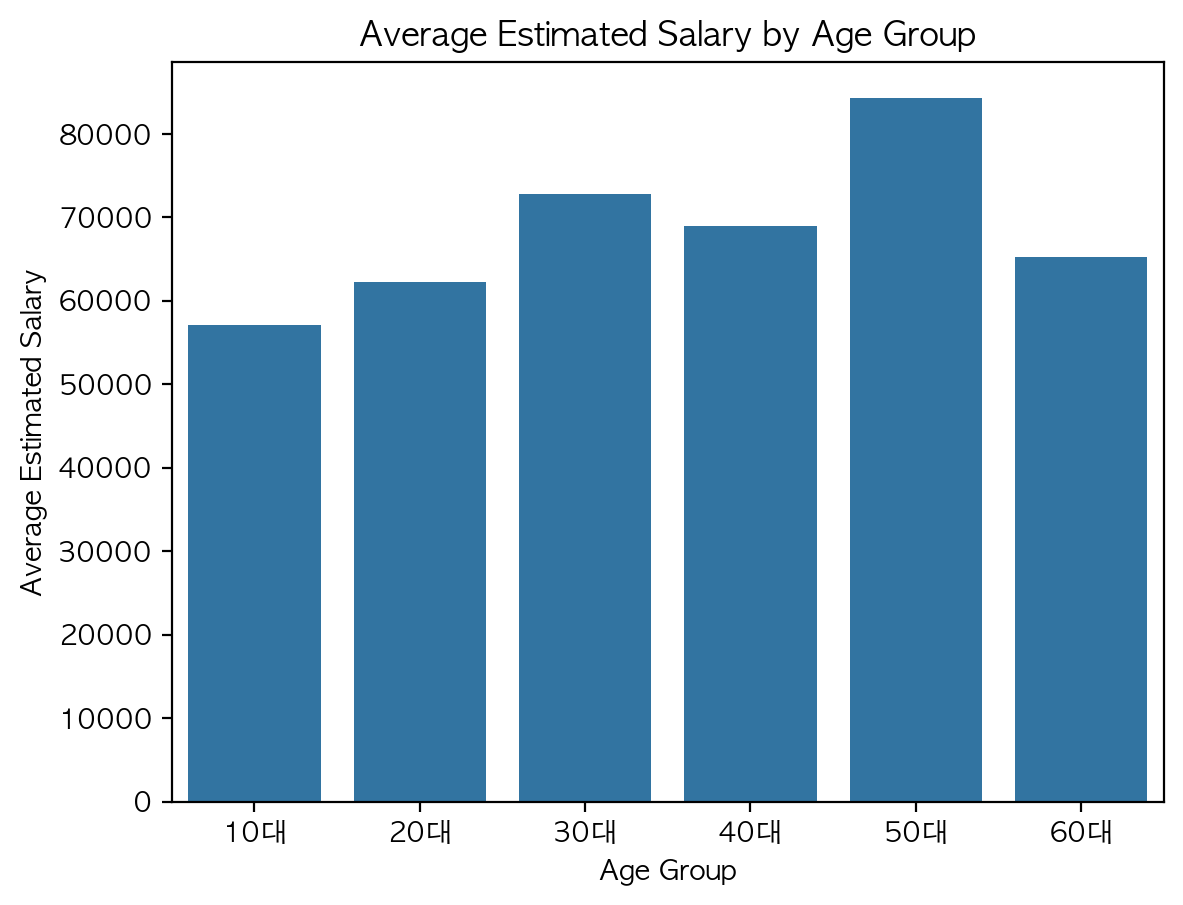

In [122]:
# 나이대를 좀 더 정확하게 설정하여 50대와 60대를 구분합니다.
data['AgeGroup'] = pd.cut(data['Age'], bins=[10, 20, 30, 40, 50, 59, 69], labels=[
    '10대', '20대', '30대', '40대', '50대', '60대'])

# 나이대별 EstimatedSalary의 평균을 계산하여 시각화합니다.
age_group_income = data.groupby('AgeGroup')['EstimatedSalary'].mean().reset_index()

# barplot 생성
sns.barplot(data=age_group_income, x='AgeGroup', y='EstimatedSalary')

# 그래프 제목과 축 레이블 추가
plt.title("Average Estimated Salary by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Average Estimated Salary")

# 그래프 보여주기
plt.show()

## EstimatedSalary 특성

In [123]:
data['EstimatedSalary'].value_counts()

EstimatedSalary
72000     12
80000     11
79000     10
75000      9
71000      9
          ..
123000     1
37000      1
115000     1
148000     1
139000     1
Name: count, Length: 117, dtype: int64

In [124]:
data['EstimatedSalary'].unique()

array([ 19000,  20000,  43000,  57000,  76000,  58000,  84000, 150000,
        33000,  65000,  80000,  52000,  86000,  18000,  82000,  25000,
        26000,  28000,  29000,  22000,  49000,  41000,  23000,  30000,
        74000, 137000,  16000,  44000,  90000,  27000,  72000,  31000,
        17000,  51000, 108000,  15000,  79000,  54000, 135000,  89000,
        32000,  83000,  55000,  48000, 117000,  87000,  66000, 120000,
        63000,  68000, 113000, 112000,  42000,  88000,  62000, 118000,
        85000,  81000,  50000, 116000, 123000,  73000,  37000,  59000,
       149000,  21000,  35000,  71000,  61000,  75000,  53000, 107000,
        96000,  45000,  47000, 100000,  38000,  69000, 148000, 115000,
        34000,  60000,  70000,  36000,  39000, 134000, 101000, 130000,
       114000, 142000,  78000, 143000,  91000, 144000, 102000, 126000,
       133000, 147000, 104000, 146000, 122000,  97000,  95000, 131000,
        77000, 125000, 106000, 141000,  93000, 138000, 119000, 105000,
      

<Axes: xlabel='Age', ylabel='EstimatedSalary'>

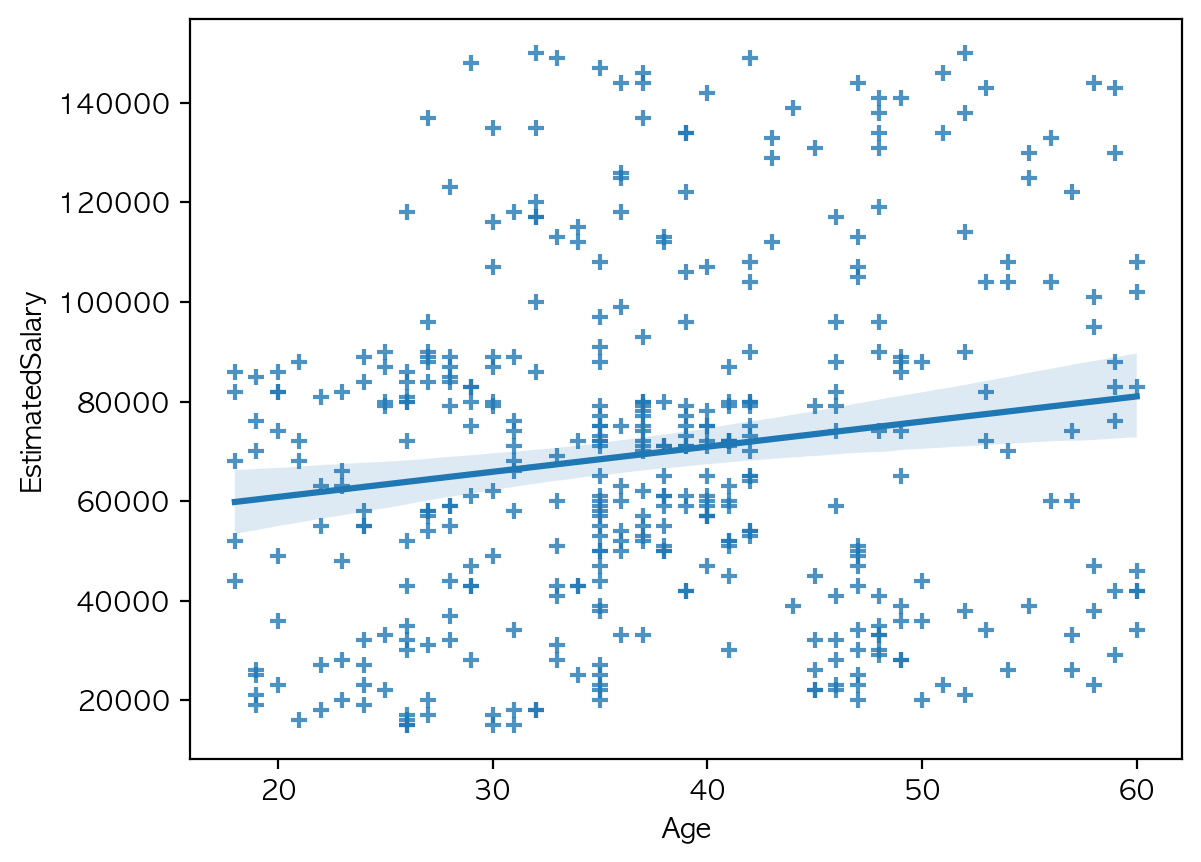

In [125]:
sns.regplot(
    data=data,
    x='Age',
    y='EstimatedSalary',
    marker='+'
)

/var/folders/dn/kpsvhr056zz6gvcnmgrkklzr0000gn/T/ipykernel_87311/1886809067.py:7: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.




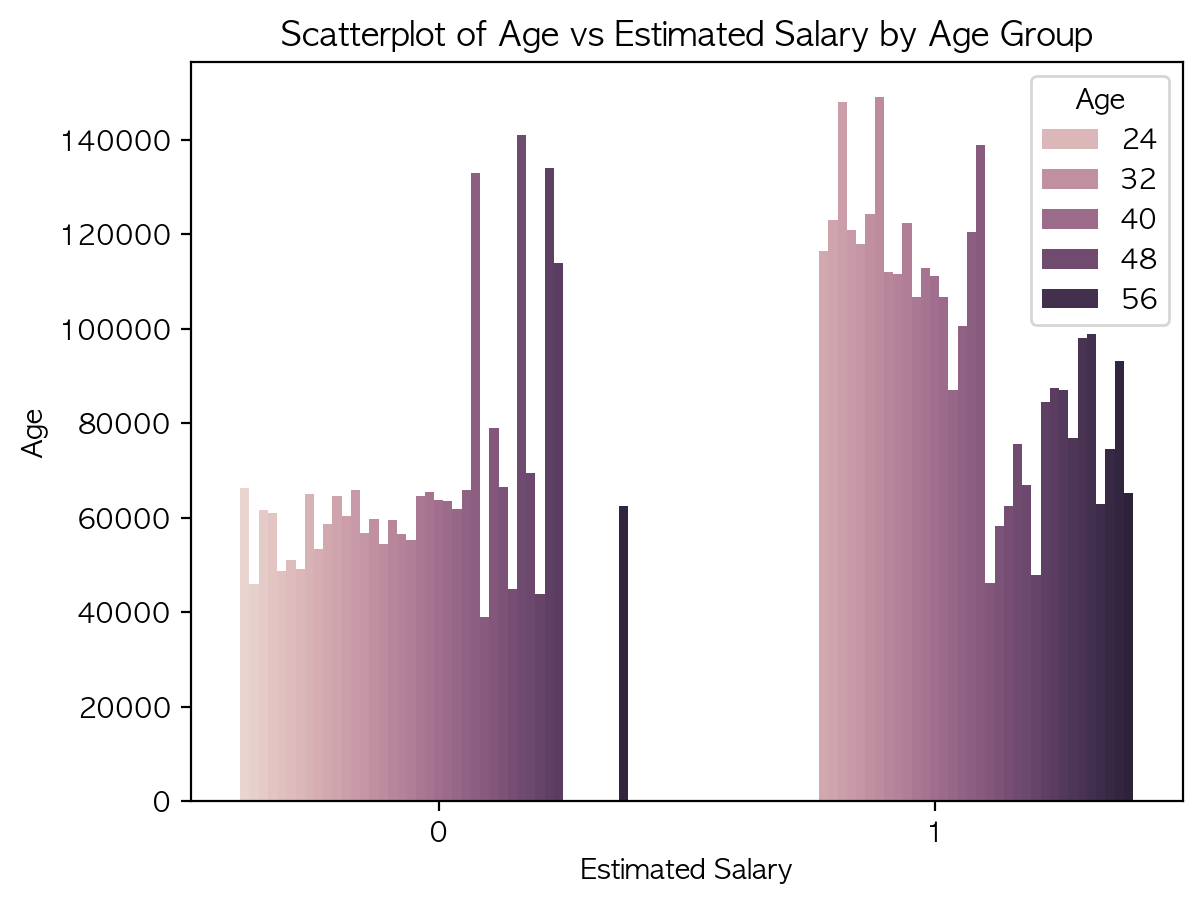

In [126]:
# 나이대 구분을 위한 범주 생성
bins = [10, 20, 30, 40, 50, 60, 70]  # 연령대 경계 값
labels = ['10대', '20대', '30대', '40대', '50대', '60대']  # 각 구간의 레이블
data['AgeGroup'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

# scatterplot 생성
sns.barplot(
    data=data,
    x='Purchased',
    y='EstimatedSalary',
    hue='Age',
    ci=False
)

# 그래프 제목과 축 레이블 추가 (optional)
plt.title("Scatterplot of Age vs Estimated Salary by Age Group")
plt.xlabel("Estimated Salary")
plt.ylabel("Age")

plt.show()

In [127]:
df = create_dataframe_purchased_rate('EstimatedSalary').T
df.head()

,Purchased,Not Purchased
EstimatedSalary,,
144000,4.0,NaN
88000,4.0,3.0
104000,4.0,NaN
23000,4.0,3.0
33000,3.0,3.0


In [128]:
print(df['Purchased'].value_counts())
print(df['Not Purchased'].value_counts())
print(df.value_counts())

Purchased
1.0    42
2.0    29
3.0     9
4.0     4
Name: count, dtype: int64
Not Purchased
1.0     25
3.0     17
2.0     14
4.0      8
5.0      6
8.0      4
6.0      4
7.0      2
11.0     1
10.0     1
Name: count, dtype: int64
Purchased  Not Purchased
2.0        1.0              7
1.0        1.0              6
3.0        1.0              5
1.0        3.0              4
2.0        3.0              4
1.0        5.0              3
           2.0              3
2.0        2.0              3
1.0        4.0              2
           8.0              2
2.0        5.0              2
3.0        3.0              2
4.0        3.0              2
1.0        10.0             1
           11.0             1
2.0        8.0              1
3.0        2.0              1
Name: count, dtype: int64


<Axes: xlabel='count', ylabel='Count'>

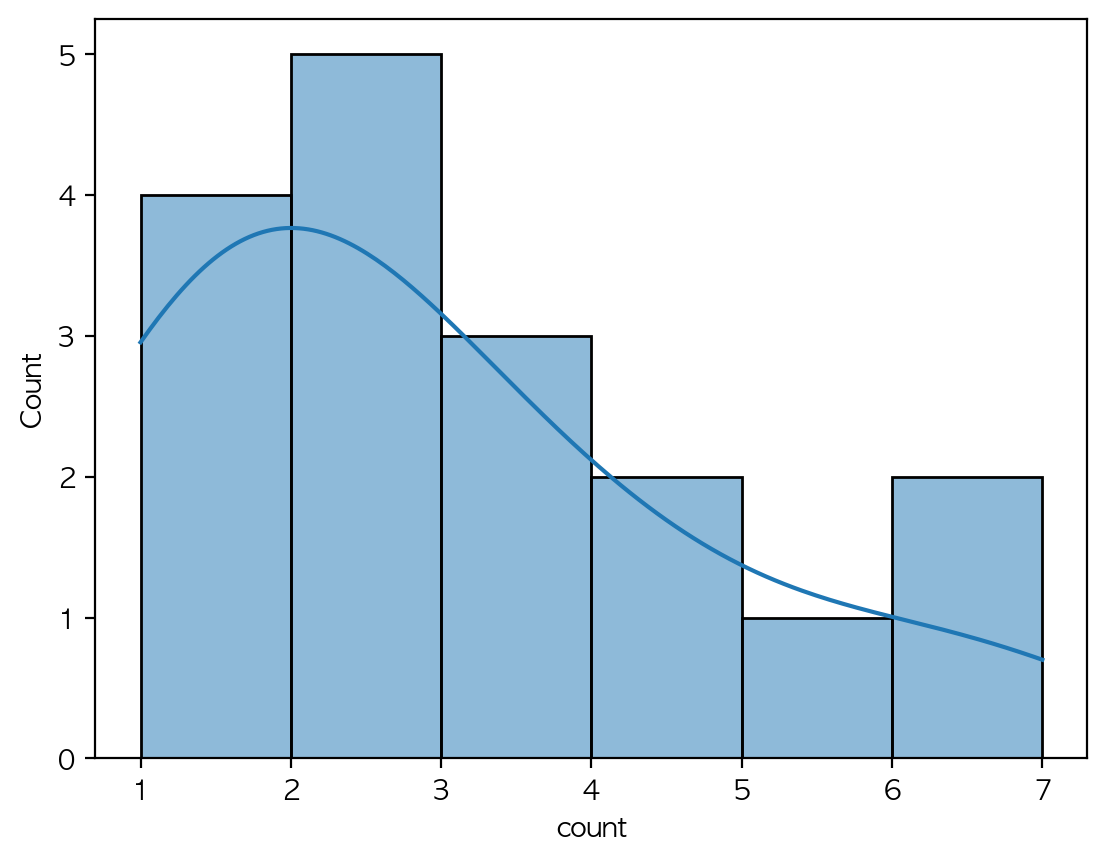

In [129]:
sns.histplot(df.value_counts(),kde=True)

# sns.barplot(df,ci=False)

## Purchased 특성
- 0 과 1로 되어있다.

In [130]:
data['Purchased'].value_counts()

Purchased
0    257
1    143
Name: count, dtype: int64

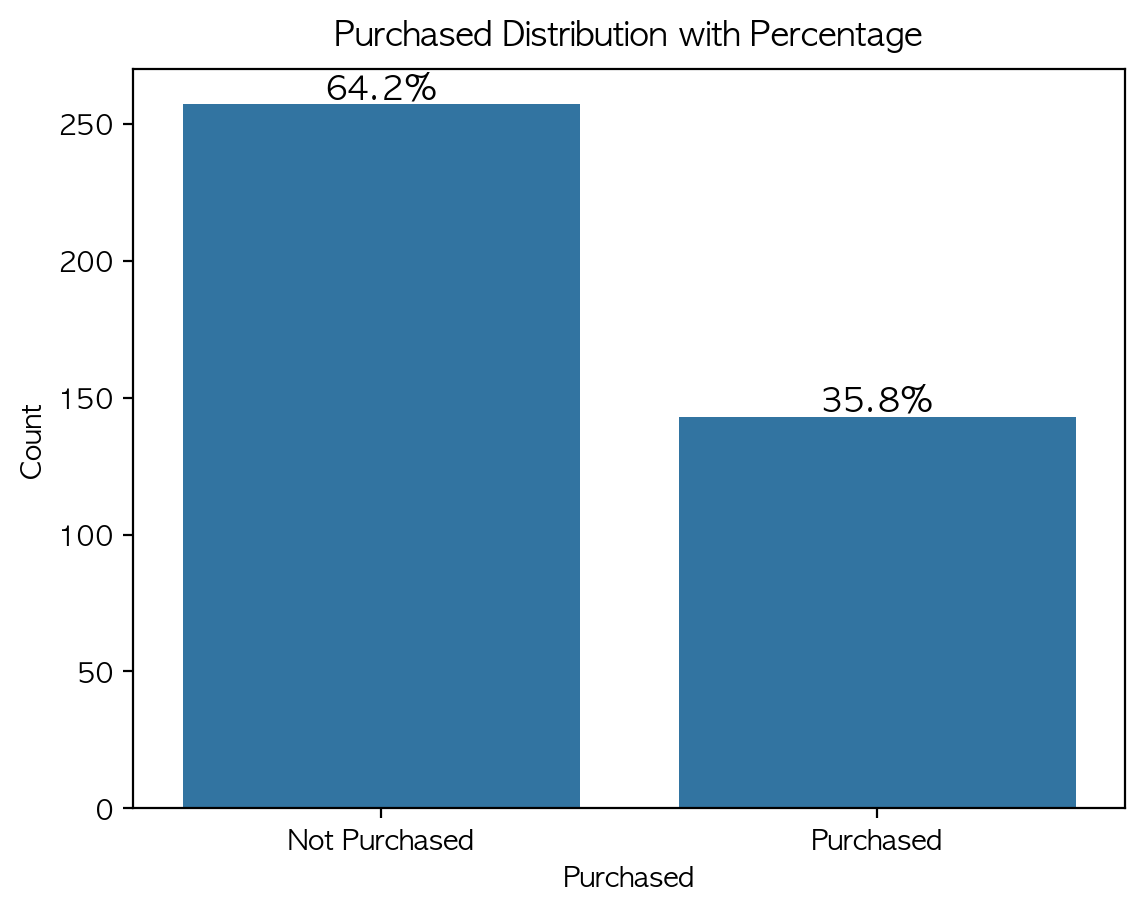

In [131]:
# countplot 생성
sns.countplot(
    data=data,
    x='Purchased',
)

# 전체 데이터에서 각 카테고리의 비율 계산 및 표시
total = len(data)  # 데이터의 총 개수
for p in plt.gca().patches:
    height = p.get_height()
    percentage = f'{height / total * 100:.1f}%'  # 비율 계산
    # 텍스트 위치를 막대 바로 위로 조정 (더 낮게)
    plt.gca().text(p.get_x() + p.get_width() / 2, height , percentage, 
                   ha='center', va='bottom', fontsize=12)

# 타이틀 위치 조정 (y=1.0으로 기본 위치로 설정)
plt.title("Purchased Distribution with Percentage", y=1.01)

# x축 레이블 추가 (선택 사항)
plt.xlabel("Purchased")

# y축 레이블 추가 (선택 사항)
plt.ylabel("Count")
plt.xticks([0,1],['Not Purchased','Purchased'])

# 그래프 표시
plt.show()

# 전처리

#### User ID 피처 제거
- 고유값으로 분석에 필요없음

In [132]:
data = data.drop(columns=['User ID'])
data

,Gender,Age,EstimatedSalary,Purchased,Age_Group,AgeGroup
0,Male,19,19000,0,10대,10대
1,Male,35,20000,0,30대,30대
2,Female,26,43000,0,20대,20대
3,Female,27,57000,0,20대,20대
4,Male,19,76000,0,10대,10대
...,...,...,...,...,...,...
395,Female,46,41000,1,40대,40대
396,Male,51,23000,1,50대,50대
397,Female,50,20000,1,50대,50대
398,Male,36,33000,0,30대,30대


#### Gender Mapping
- 남자 : 0
- 여자 : 1

In [133]:
mapping_gender = {'Male':0,'Female':1}
data['Gender'] = data['Gender'].map(mapping_gender)

In [134]:
data['Gender'].value_counts()

Gender
1    204
0    196
Name: count, dtype: int64

<Axes: xlabel='Gender', ylabel='Purchased'>

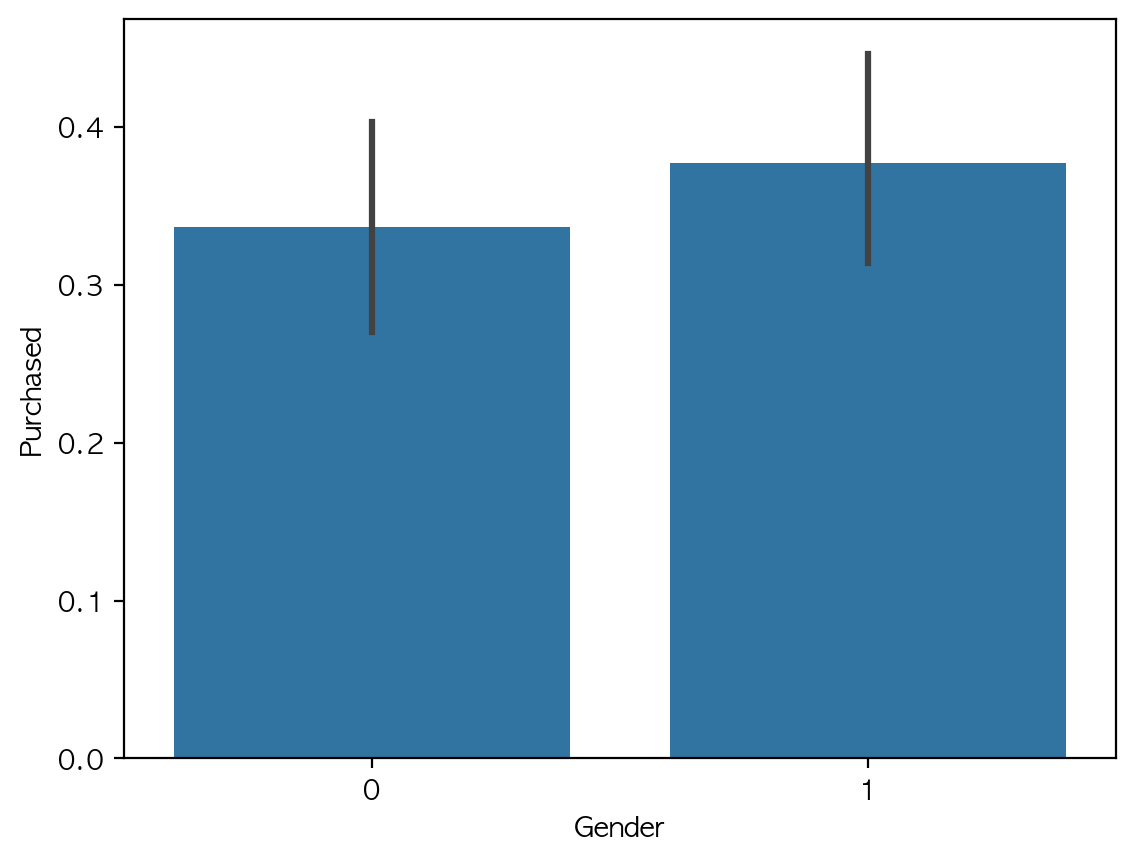

In [135]:
sns.barplot(
    data,
    x='Gender',
    y='Purchased'
)

<Axes: xlabel='Gender', ylabel='Purchased'>

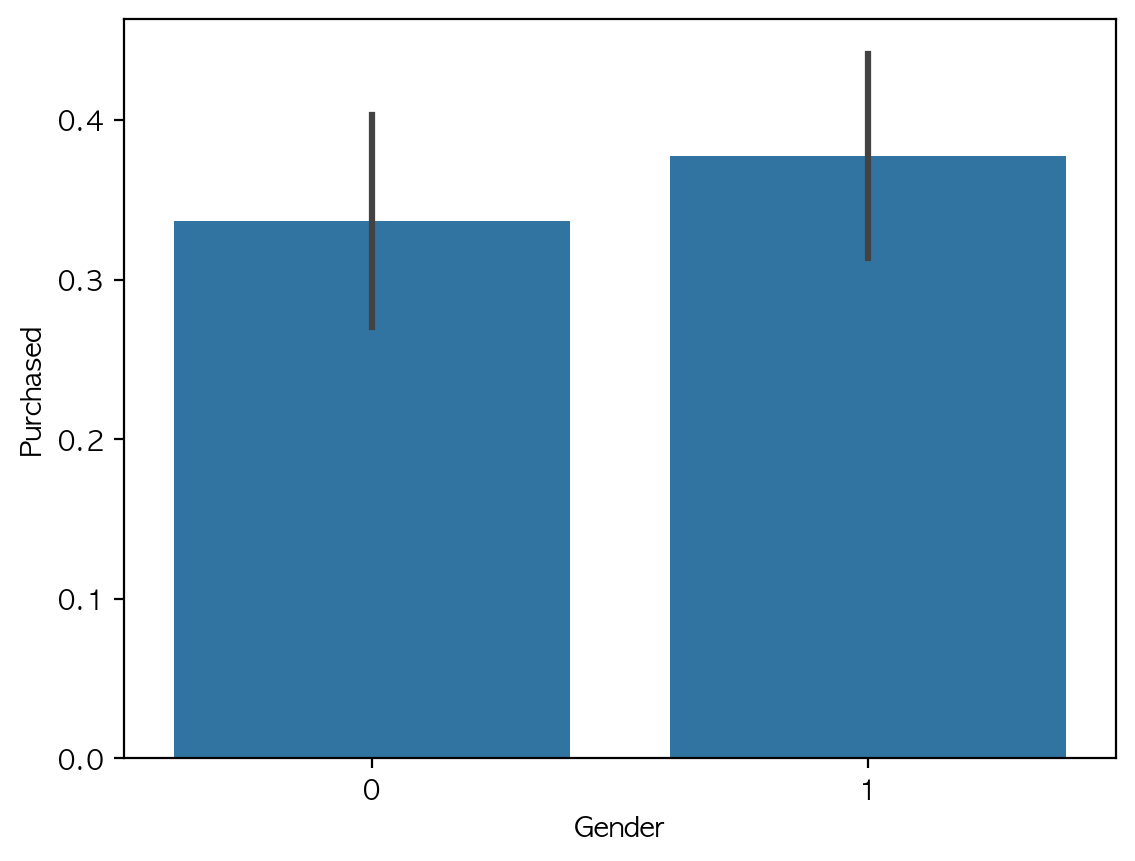

In [136]:
sns.barplot(
    data,
    x='Gender',
    y='Purchased'
)

#### Age_Group 피처 생성
- 연령대별 구별

In [137]:
data['Age_Group'] = pd.cut(data['Age'], bins=[10, 19, 29, 39, 49, 59, 69], 
                           labels=[10, 20, 30, 40, 50, 60], right=True)

#### 연령대별 인원

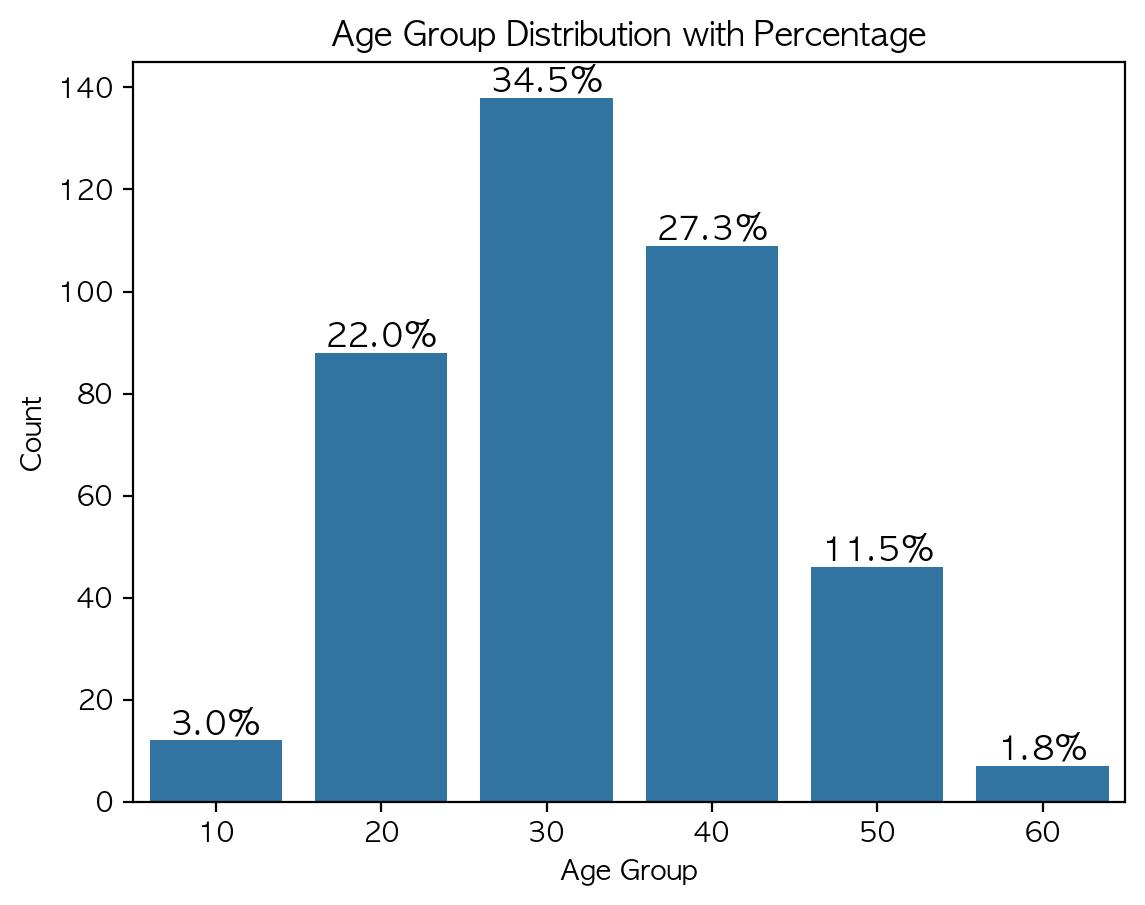

In [138]:
sns.countplot(
    x = data['Age_Group'],
)

total = len(data)  # 데이터의 총 개수
for p in plt.gca().patches:
    height = p.get_height()
    percentage = f'{height / total * 100:.1f}%'  # 비율 계산
    # 텍스트 위치를 막대 위로 조정
    plt.gca().text(p.get_x() + p.get_width() / 2, height+0.1, percentage, 
                   ha='center', va='bottom', fontsize=12)

# 그래프 제목 추가 (선택 사항)
plt.title("Age Group Distribution with Percentage")

# x축 레이블 추가 (선택 사항)
plt.xlabel("Age Group")

# y축 레이블 추가 (선택 사항)
plt.ylabel("Count")

# 그래프 표시
plt.show()

/var/folders/dn/kpsvhr056zz6gvcnmgrkklzr0000gn/T/ipykernel_87311/3697887854.py:1: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.




<Axes: xlabel='Age_Group', ylabel='EstimatedSalary'>

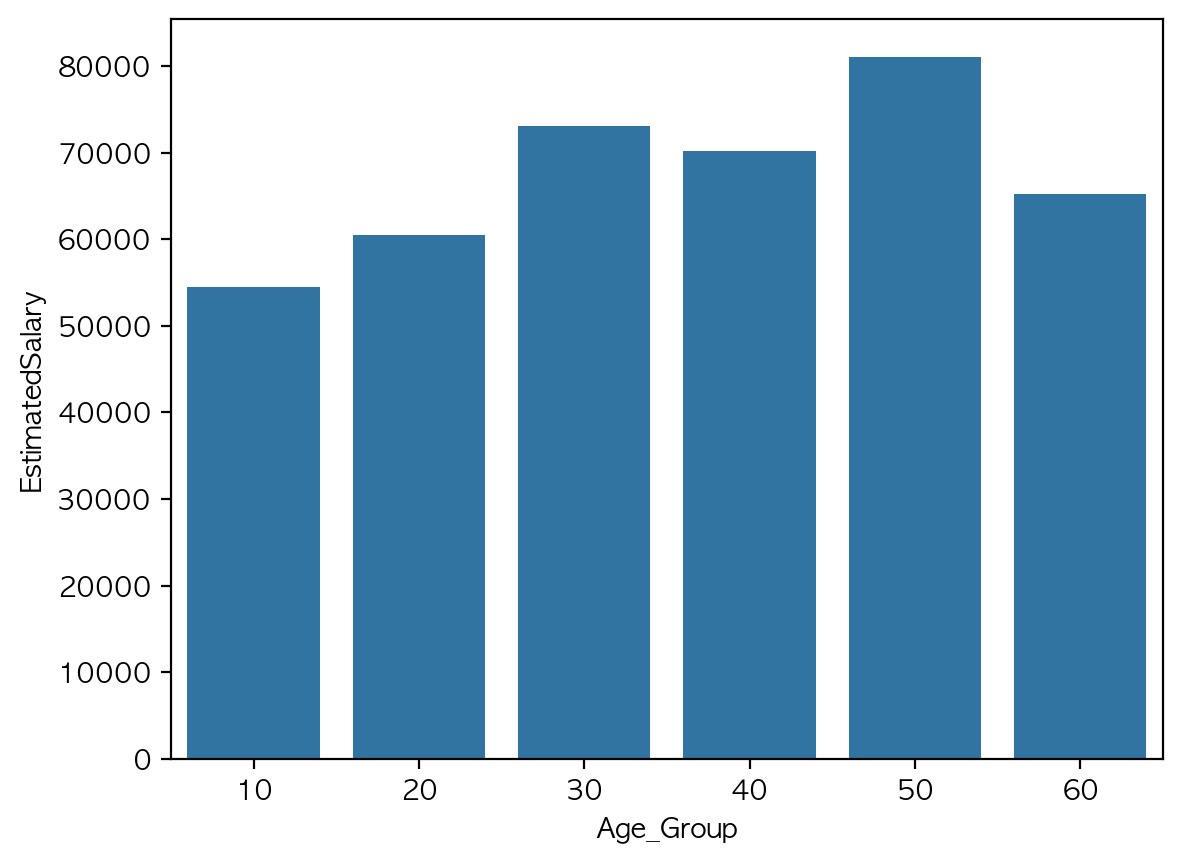

In [139]:
sns.barplot(
    data,
    x='Age_Group',
    y='EstimatedSalary',
    ci=False
)

### 연령대별 구매비율

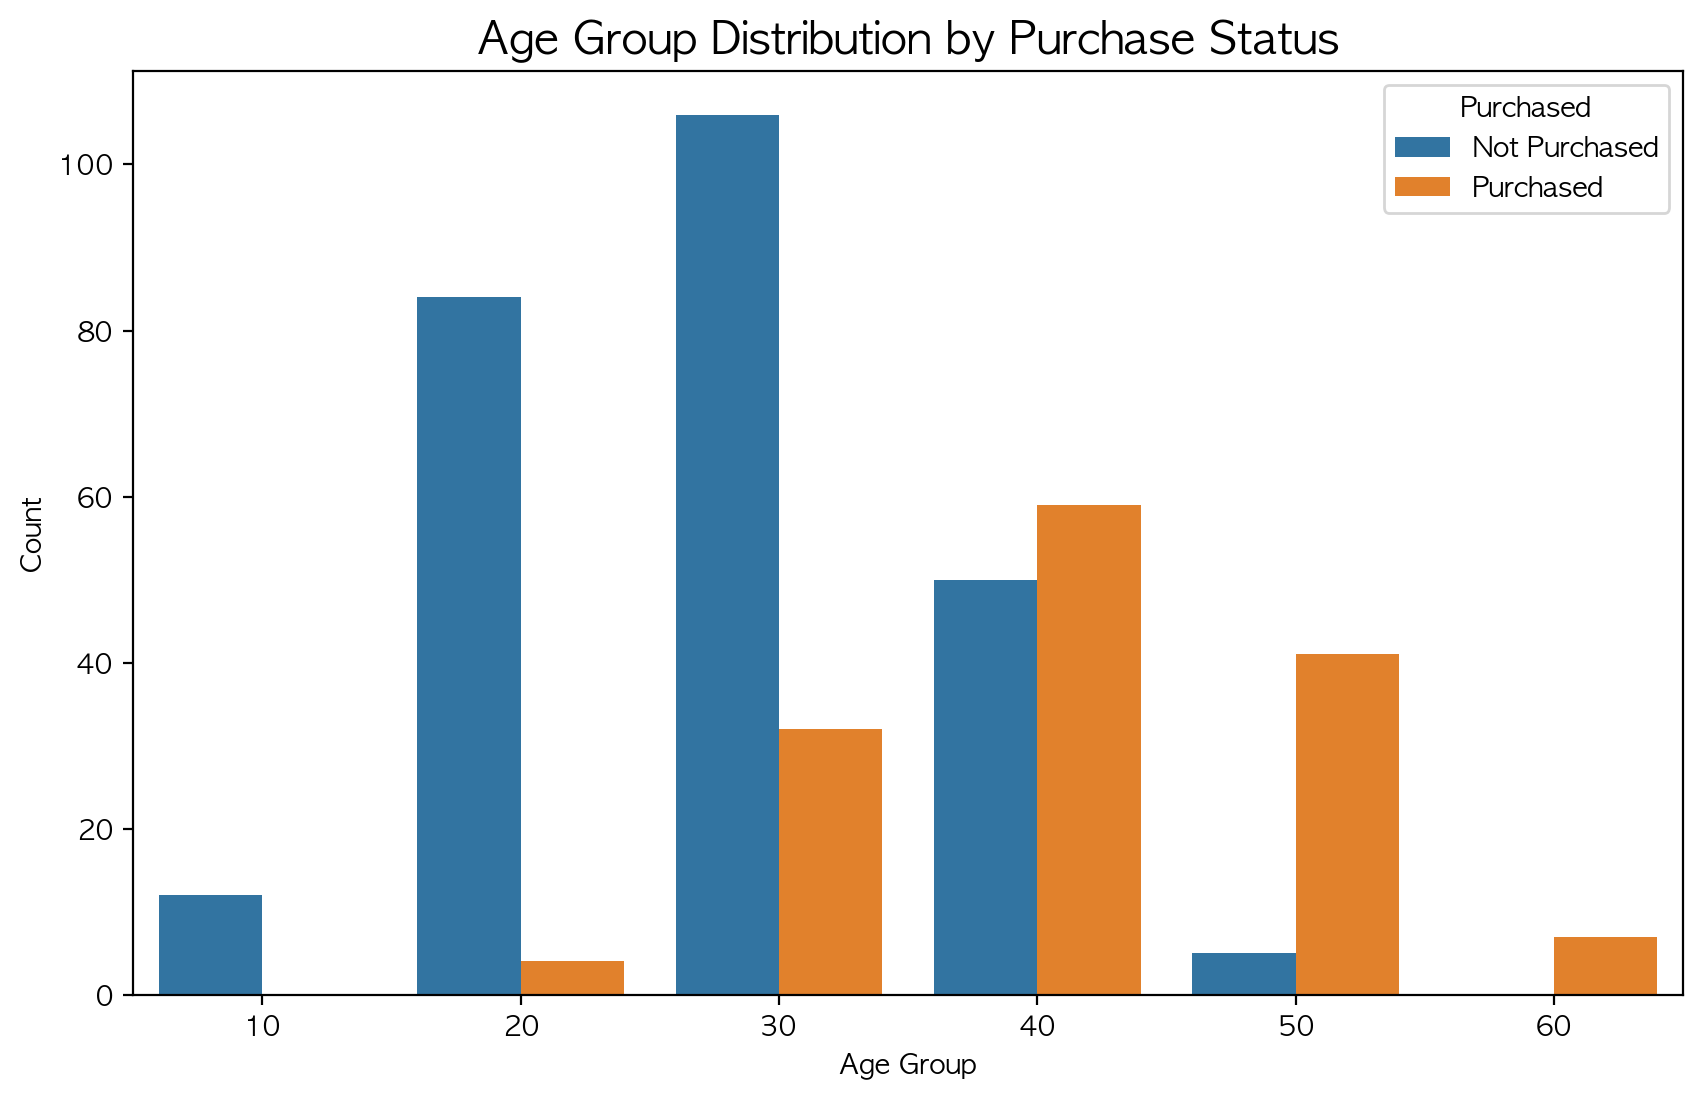

In [140]:
age_group_labels = {10: '10대', 20: '20대', 30: '30대', 40: '40대', 50: '50대', 60: '60대'}
data['Age_Group'].map(age_group_labels)
# 데이터프레임을 사용하여 'Purchased' 여부에 따라 그룹화
data_grouped = data.groupby(['Age_Group', 'Purchased'], observed=False).size().reset_index(name='Count')

# 'Purchased' 값을 범주형으로 변환
data_grouped['Purchased'] = data_grouped['Purchased'].map({1: 'Purchased', 0: 'Not Purchased'})

# 하나의 그래프로 시각화
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Age_Group', y='Count', hue='Purchased', data=data_grouped)

# 그래프 제목 및 축 레이블 설정
plt.title('Age Group Distribution by Purchase Status', fontsize=16)
plt.xlabel('Age Group')
plt.ylabel('Count')

# 그래프 표시
plt.show()

/var/folders/dn/kpsvhr056zz6gvcnmgrkklzr0000gn/T/ipykernel_87311/2936626837.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



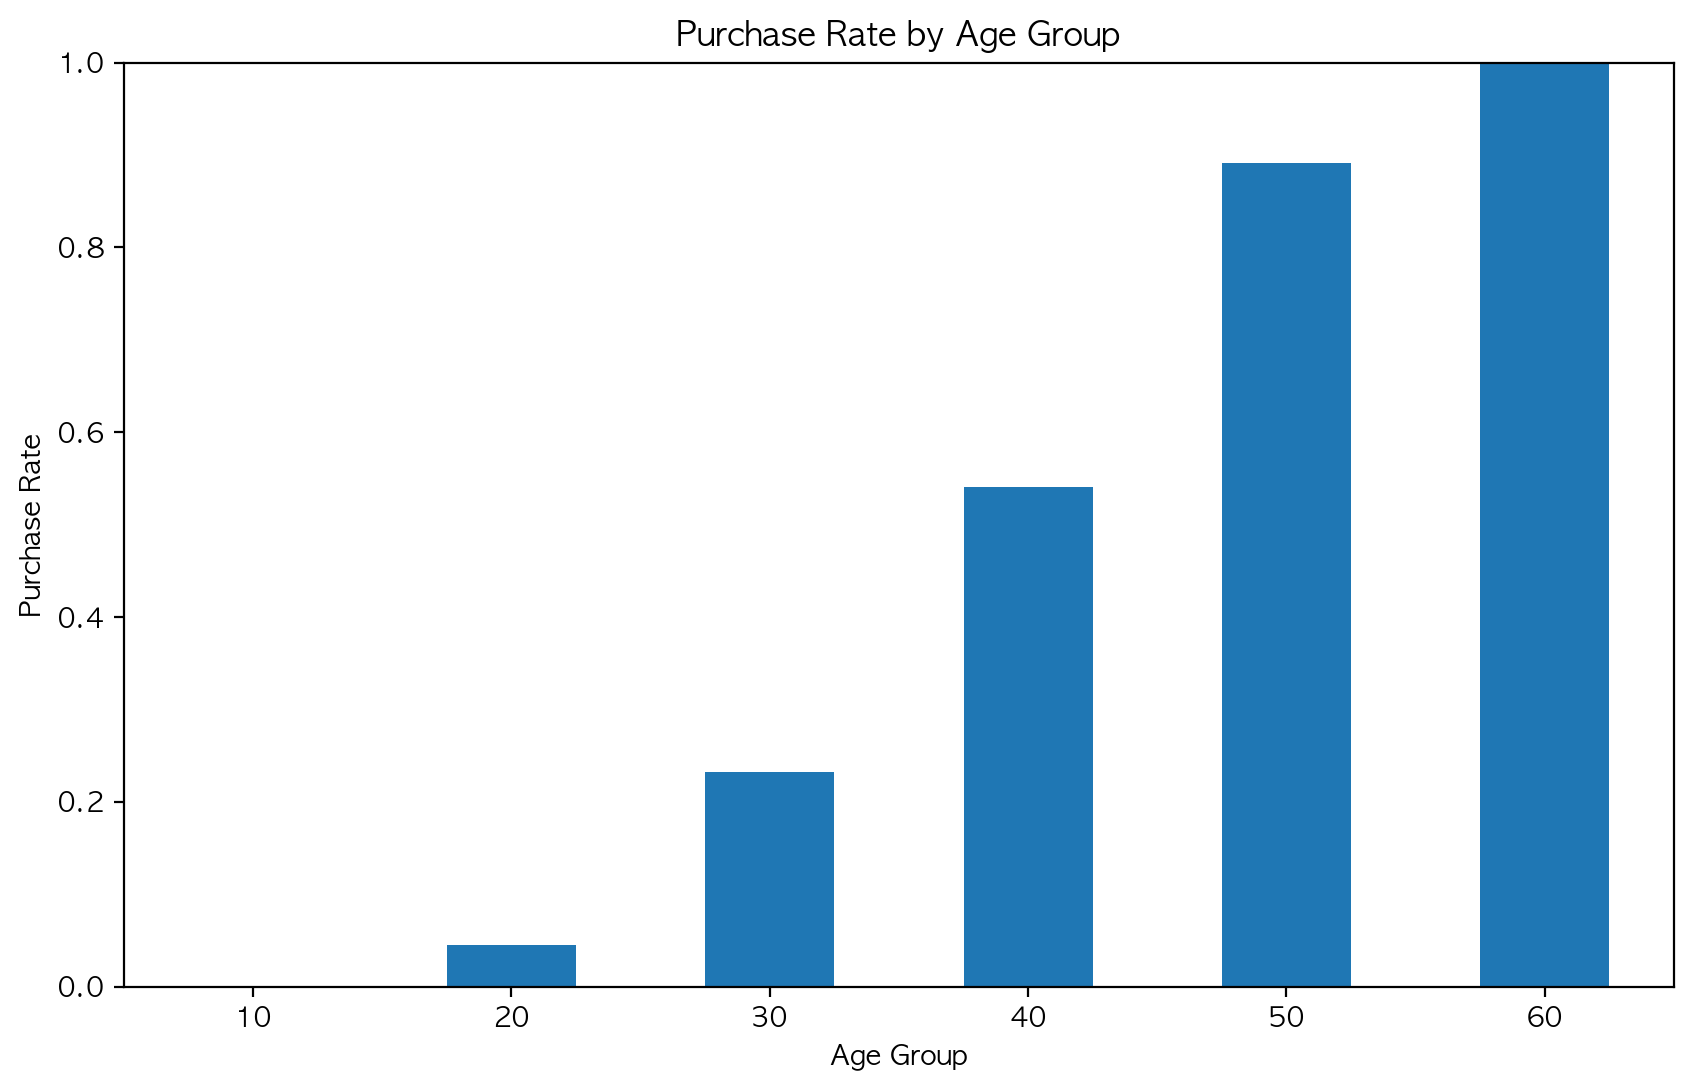

Age_Group
10    0.000000
20    0.045455
30    0.231884
40    0.541284
50    0.891304
60    1.000000
Name: Purchased, dtype: float64

In [141]:
# 연령대별 구매율 계산
purchase_rate_by_age_group = data.groupby('Age_Group')['Purchased'].mean()

# 구매율 시각화
plt.figure(figsize=(10, 6))
purchase_rate_by_age_group.plot(kind='bar')
plt.title('Purchase Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Purchase Rate')
plt.ylim(0, 1)  # 구매율은 0~1 사이의 값이므로 y축 범위를 설정
plt.xticks(rotation=0)
plt.show()

# 연령대별 구매율 데이터 출력
purchase_rate_by_age_group

### 연령대별 성별에 따른 구매율 계산

/var/folders/dn/kpsvhr056zz6gvcnmgrkklzr0000gn/T/ipykernel_87311/1950906491.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<Figure size 1200x800 with 0 Axes>

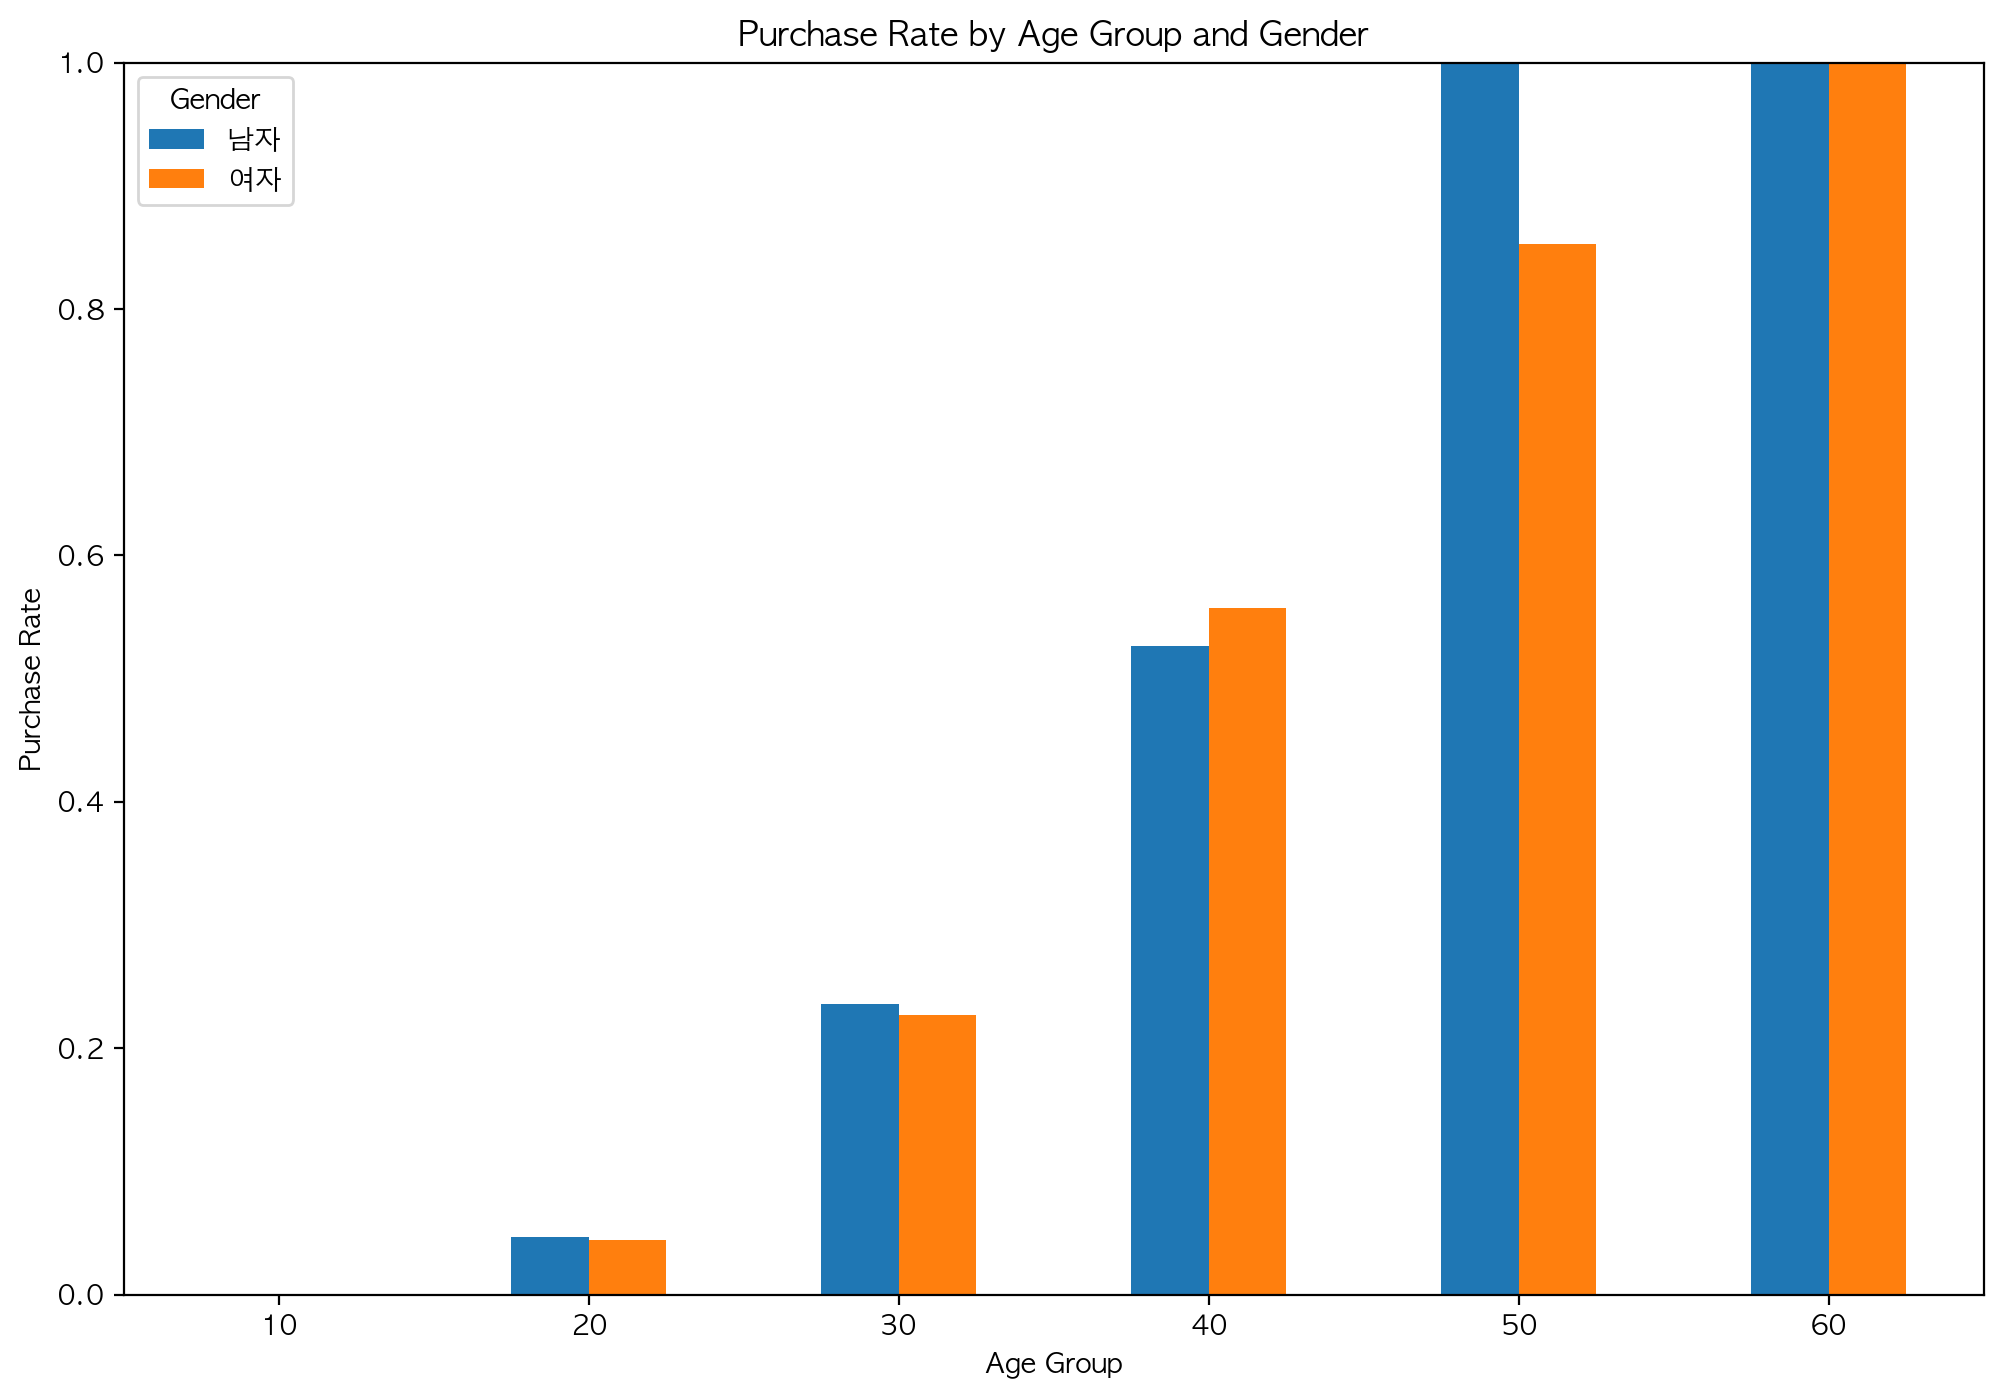

Gender,0,1
Age_Group,,
10,0.000000,0.000000
20,0.046512,0.044444
30,0.236111,0.227273
40,0.526316,0.557692
50,1.000000,0.852941
60,1.000000,1.000000


In [142]:
# 연령대별 성별에 따른 구매율 계산
purchase_rate_by_age_gender = data.groupby(['Age_Group', 'Gender'])['Purchased'].mean().unstack()

# 구매율 시각화
plt.figure(figsize=(12, 8))
purchase_rate_by_age_gender.plot(kind='bar', figsize=(12, 8))
plt.title('Purchase Rate by Age Group and Gender')
plt.xlabel('Age Group')
plt.ylabel('Purchase Rate')
plt.ylim(0, 1)  # 구매율은 0~1 사이의 값이므로 y축 범위를 설정
plt.xticks(rotation=0)
plt.legend(title='Gender', labels=['남자', '여자'])
plt.show()

# 연령대별 성별에 따른 구매율 데이터 출력
purchase_rate_by_age_gender

### 연령대별 평균 소득 계산

/var/folders/dn/kpsvhr056zz6gvcnmgrkklzr0000gn/T/ipykernel_87311/2016560049.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



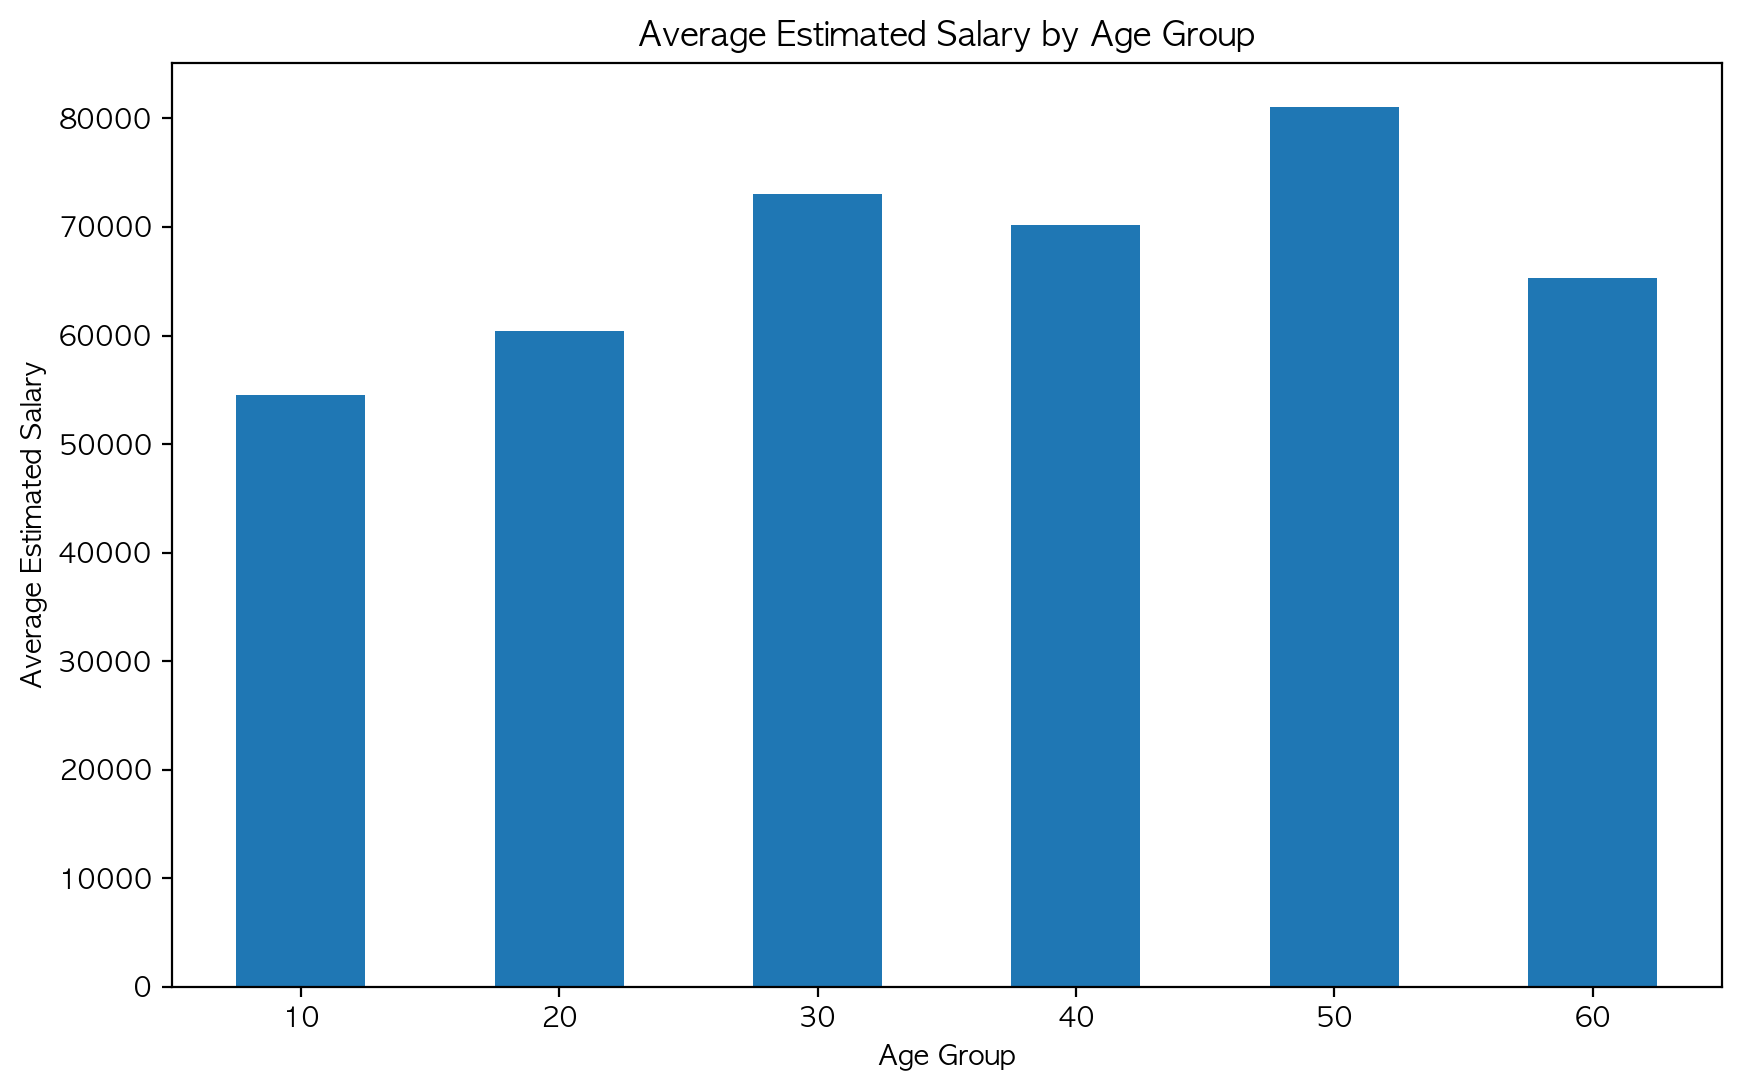

Age_Group
10    54500.000000
20    60443.181818
30    73079.710145
40    70201.834862
50    81086.956522
60    65285.714286
Name: EstimatedSalary, dtype: float64

In [143]:
# 연령대별 평균 소득 계산
average_salary_by_age_group = data.groupby('Age_Group')['EstimatedSalary'].mean()

# 평균 소득 시각화
plt.figure(figsize=(10, 6))
average_salary_by_age_group.plot(kind='bar')
plt.title('Average Estimated Salary by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Estimated Salary')
plt.xticks(rotation=0)
plt.show()

# 연령대별 평균 소득 데이터 출력
average_salary_by_age_group

In [144]:
data['Age_Group'] = pd.cut(data['Age'], bins=[10, 19, 29, 39, 49, 59, 69], 
                           labels=[10, 20, 30, 40, 50, 60], right=True)

data.drop(columns=['AgeGroup'],inplace=True)

### 스케일링

In [145]:
scaler = MinMaxScaler()

scaled_data = scaler.fit(data)

In [146]:
scaled_data_df = pd.DataFrame(scaled_data.transform(data),columns=data.columns)
scaled_data_df

,Gender,Age,EstimatedSalary,Purchased,Age_Group
0,0.0,0.023810,0.029630,0.0,0.0
1,0.0,0.404762,0.037037,0.0,0.4
2,1.0,0.190476,0.207407,0.0,0.2
3,1.0,0.214286,0.311111,0.0,0.2
4,0.0,0.023810,0.451852,0.0,0.0
...,...,...,...,...,...
395,1.0,0.666667,0.192593,1.0,0.6
396,0.0,0.785714,0.059259,1.0,0.8
397,1.0,0.761905,0.037037,1.0,0.8
398,0.0,0.428571,0.133333,0.0,0.4


<Axes: >

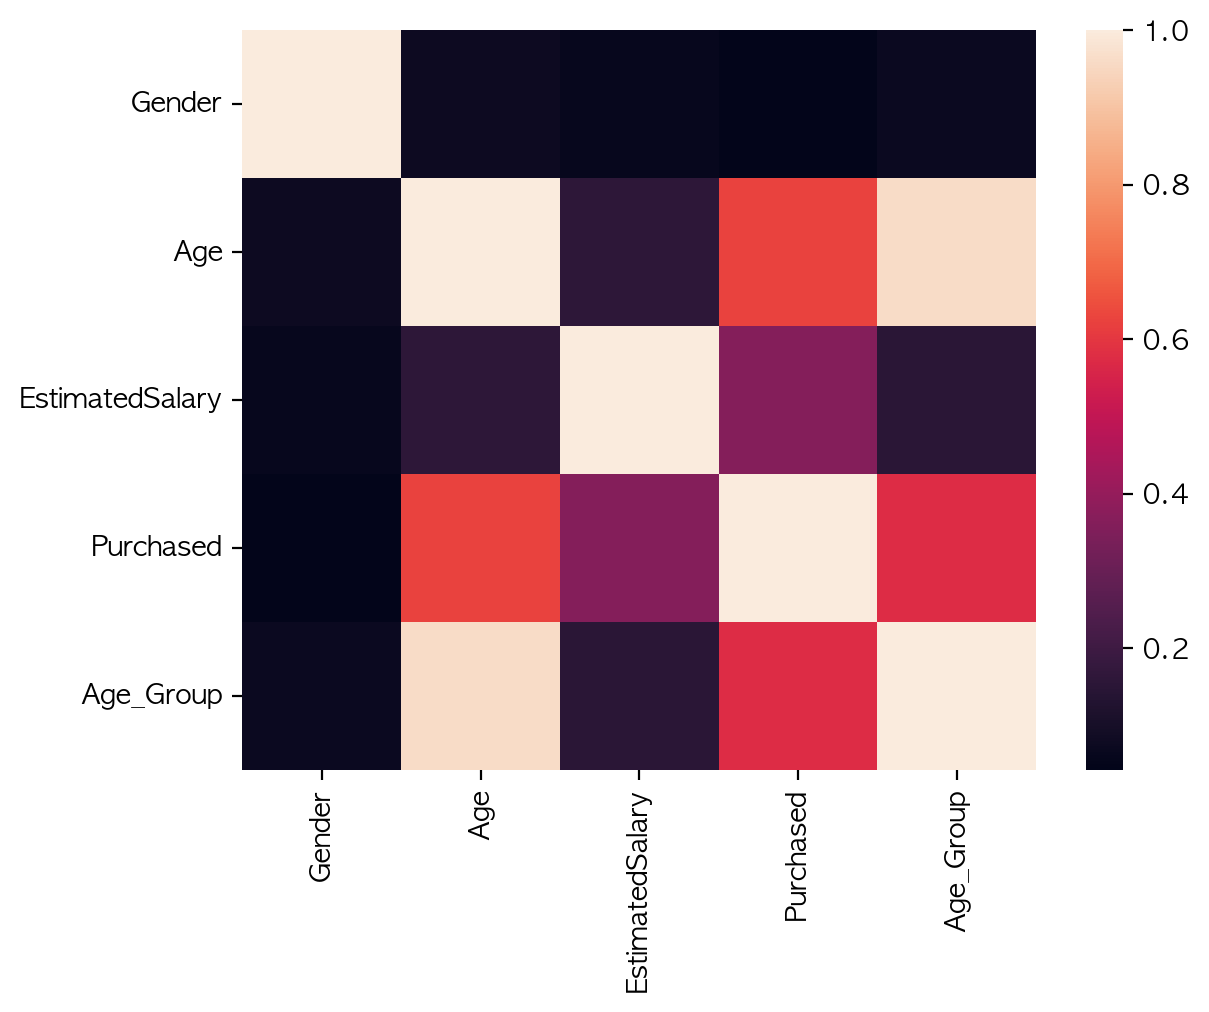

In [147]:
sns.heatmap(scaled_data_df.corr())

### 머신러닝 피처 선택

In [148]:
# X = scaled_data_df[['Gender','EstimatedSalary','Age_Group']]
X = scaled_data_df[['EstimatedSalary','Age_Group']]
y = scaled_data_df['Purchased']

# 머신러닝
- x : 성별, 연령대별 그룹, 급여
- y : 구매여부

In [149]:
X.shape

(400, 2)

In [150]:
y.shape

(400,)

### 함수

#### feature importance 시각화

In [151]:
def vis_feature_importance(feature_importances,model_name="Model"):
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x=feature_importances,
        y=X.columns
    )
    
    # 타이틀 및 라벨 추가
    plt.title(f'{model_name} Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.xlim(0,1)
    
    # 각 막대 위에 수치 표시
    for i, v in enumerate(feature_importances):
        ax.text(v + 0.01, i, f'{v:.2f}', color='black', va='center')
    
    # 그래프 표시
    plt.show()

#### confusion matrix 시각화

In [152]:
def vis_confusion_matrix(y_test, y_pred, model_name="", ax=None):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=['Not Purchased', 'Purchased'], 
                yticklabels=['Not Purchased', 'Purchased'],
                ax=ax, 
                annot_kws={"fontsize": 20})  # 텍스트 크기를 16으로 설정
    ax.set_xlabel('Predicted', fontsize=20)  # x축 레이블 크기
    ax.set_ylabel('Actual', fontsize=20)  # y축 레이블 크기
    ax.set_title('Confusion Matrix | ' + model_name, fontsize=16)  # 제목 크기 설정


### 훈련, 테스트 데이터 분할

In [153]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=12)

## Decision Tree(구매할 것이냐 안할것이냐)


In [154]:
X_train.shape

(280, 2)

In [155]:
X_test.shape

(120, 2)

### 모델 생성

In [156]:
dt = DecisionTreeClassifier(random_state=12,max_depth=5,min_samples_split=7)

### fit

In [157]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=7, random_state=12)

### 예측

In [158]:
y_pred = dt.predict(X_test)

### 평가

#### accuracy

In [159]:
dt.score(X_train,y_train)

0.9571428571428572

In [160]:
dt.score(X_test,y_test)

0.8416666666666667

In [161]:
print('accuracy_score : ',accuracy_score(y_test,y_pred))

accuracy_score :  0.8416666666666667


#### confusion matrix

In [162]:
# vis_confusion_matrix(y_test,y_pred,"Decision Tree")

#### classification report

In [163]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.89      0.87        73
         1.0       0.82      0.77      0.79        47

    accuracy                           0.84       120
   macro avg       0.84      0.83      0.83       120
weighted avg       0.84      0.84      0.84       120



#### feature importances

[0.54234169 0.45765831]


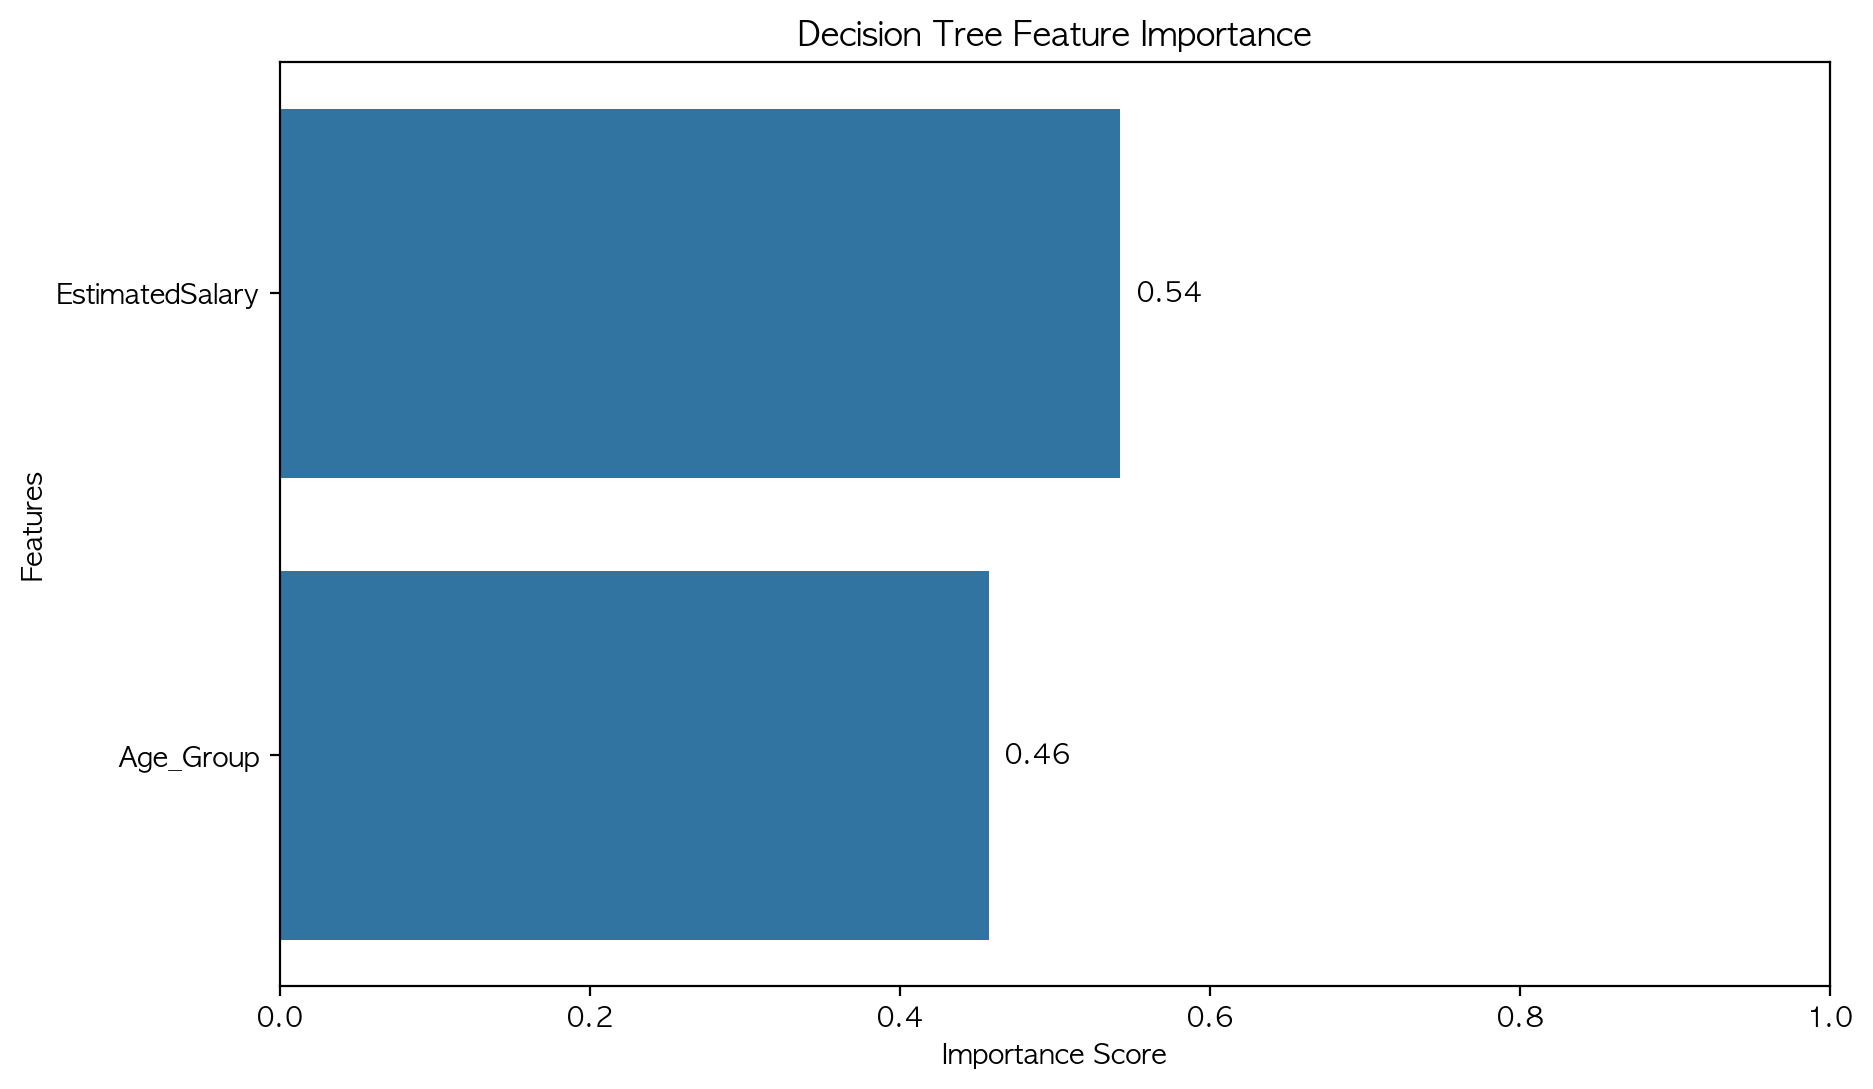

In [164]:
print(dt.feature_importances_)
vis_feature_importance(dt.feature_importances_, 'Decision Tree')

In [165]:
shap.initjs()

In [166]:
explainer = shap.KernelExplainer(dt.predict,X_train)

Using 280 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [167]:
shap_value = explainer.shap_values(X_test,nsamples=100)
shap_train = explainer.shap_values(X_train)

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

In [168]:
shap.force_plot(
    explainer.expected_value,
    shap_value,X_test
)

#### ROC / ACU

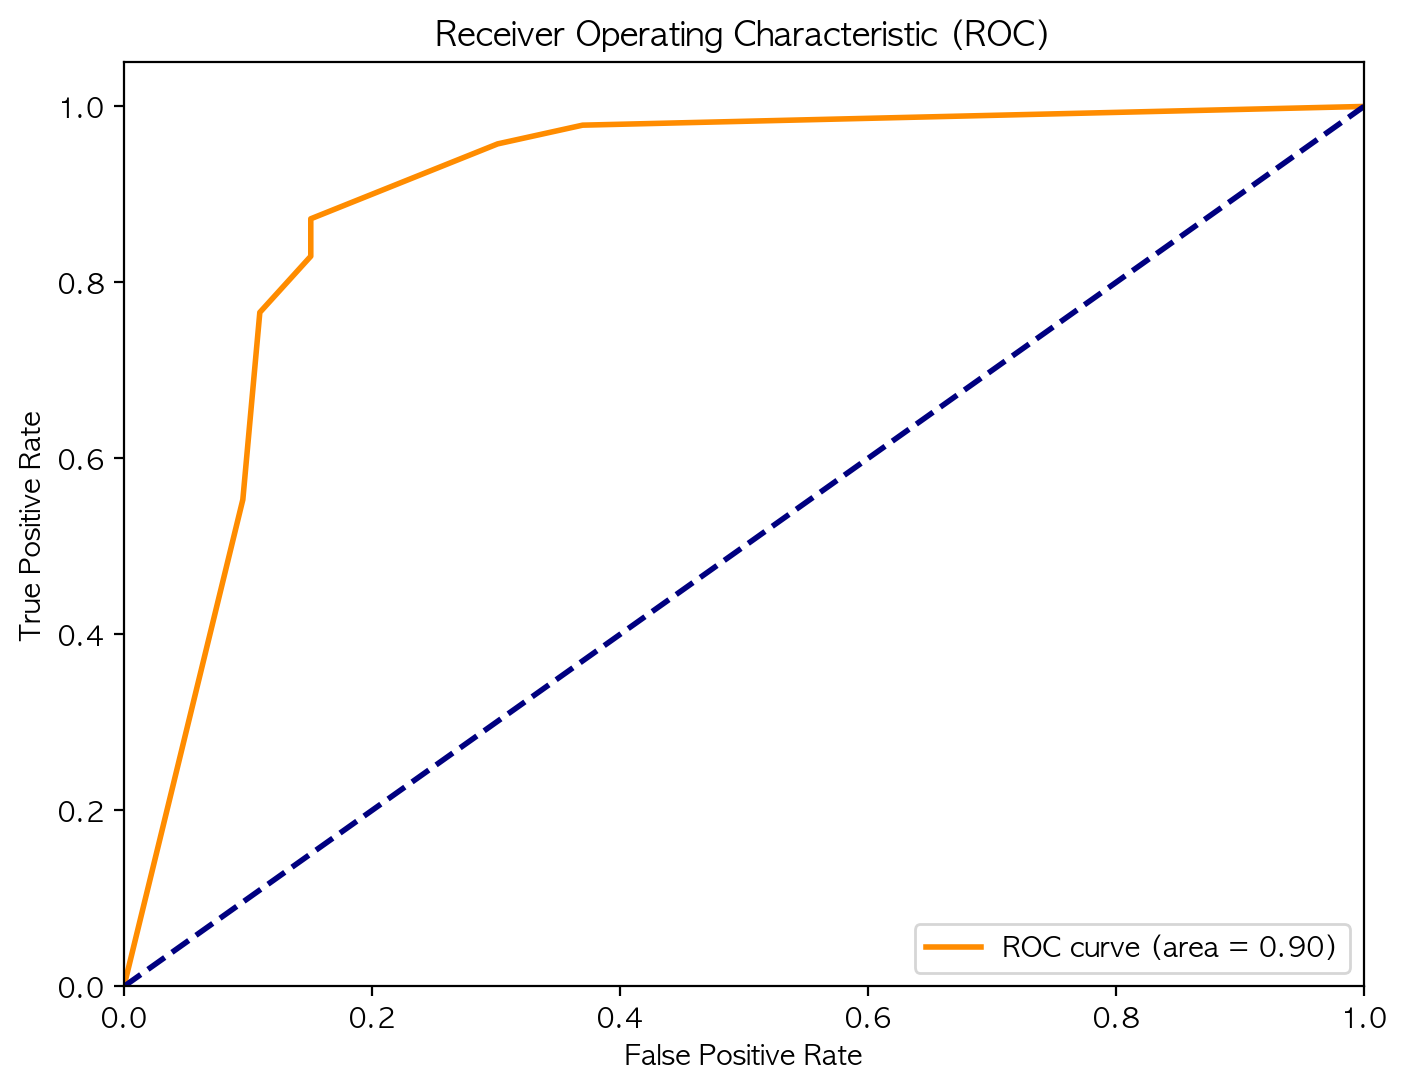

In [169]:
# 예측 확률 계산
y_prob = dt.predict_proba(X_test)[:, 1]

# ROC 곡선 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# ROC 곡선 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

#### Precision-Recall Curve

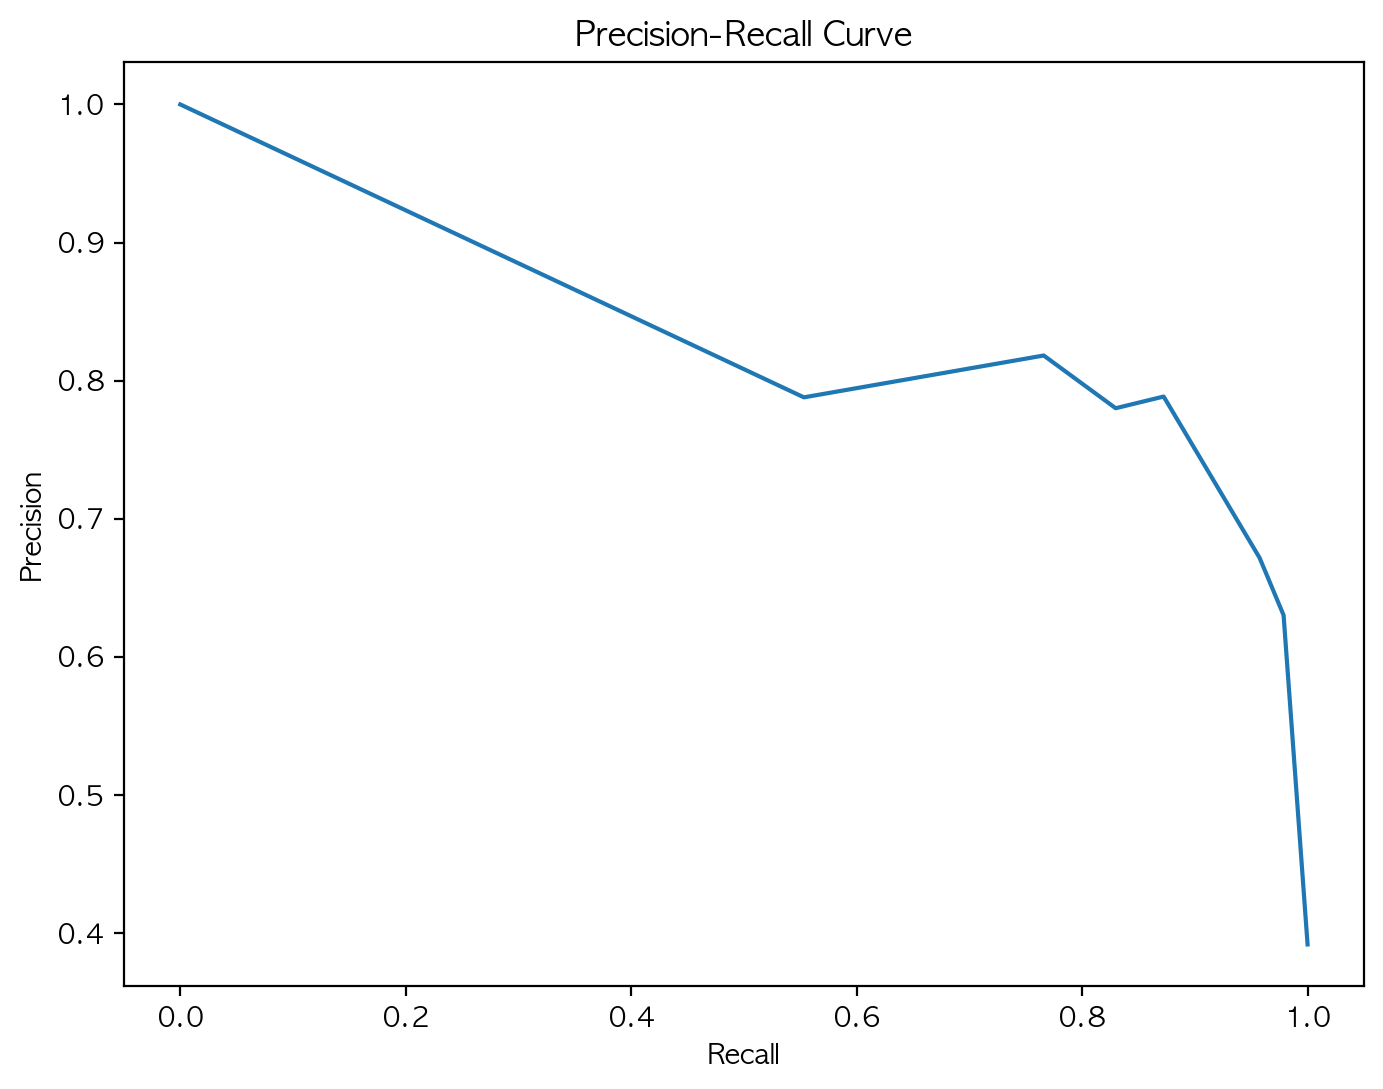

In [170]:
# 정밀도, 재현율, 임계값 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)

# Precision-Recall Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

### GridSearch

In [171]:
parameters = {'max_depth': range(1,10), 'min_samples_split': range(2,10)}
grid_dt = GridSearchCV(dt, param_grid=parameters, cv=3, refit=True, return_train_score=True)
grid_dt.fit(X_train, y_train)

# GridSearchCV result
scores_df = pd.DataFrame(grid_dt.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score']]

,params,mean_test_score,rank_test_score
0,"{'max_depth': 1, 'min_samples_split': 2}",0.789179,65
1,"{'max_depth': 1, 'min_samples_split': 3}",0.789179,65
2,"{'max_depth': 1, 'min_samples_split': 4}",0.789179,65
3,"{'max_depth': 1, 'min_samples_split': 5}",0.789179,65
4,"{'max_depth': 1, 'min_samples_split': 6}",0.789179,65
...,...,...,...
67,"{'max_depth': 9, 'min_samples_split': 5}",0.881987,37
68,"{'max_depth': 9, 'min_samples_split': 6}",0.881987,37
69,"{'max_depth': 9, 'min_samples_split': 7}",0.892740,14
70,"{'max_depth': 9, 'min_samples_split': 8}",0.892740,14


In [172]:
# best params
print(f'best params:', grid_dt.best_params_)
print(f'best score {grid_dt.best_score_:.2%}')

best params: {'max_depth': 4, 'min_samples_split': 2}
best score 89.99%


## Random Forest Classifier

In [173]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=12)

In [174]:
# rfc = RandomForestClassifier(random_state=12)
rfc = RandomForestClassifier(random_state=12,max_depth=5,min_samples_split=8)


In [175]:
rfc.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, min_samples_split=8, random_state=12)

In [176]:
y_pred = rfc.predict(X_test)

### Confusion Matrix

In [177]:
# vis_confusion_matrix(y_test,y_pred,"Random Forest Classifier")

### Feature Importance

[0.58875926 0.41124074]


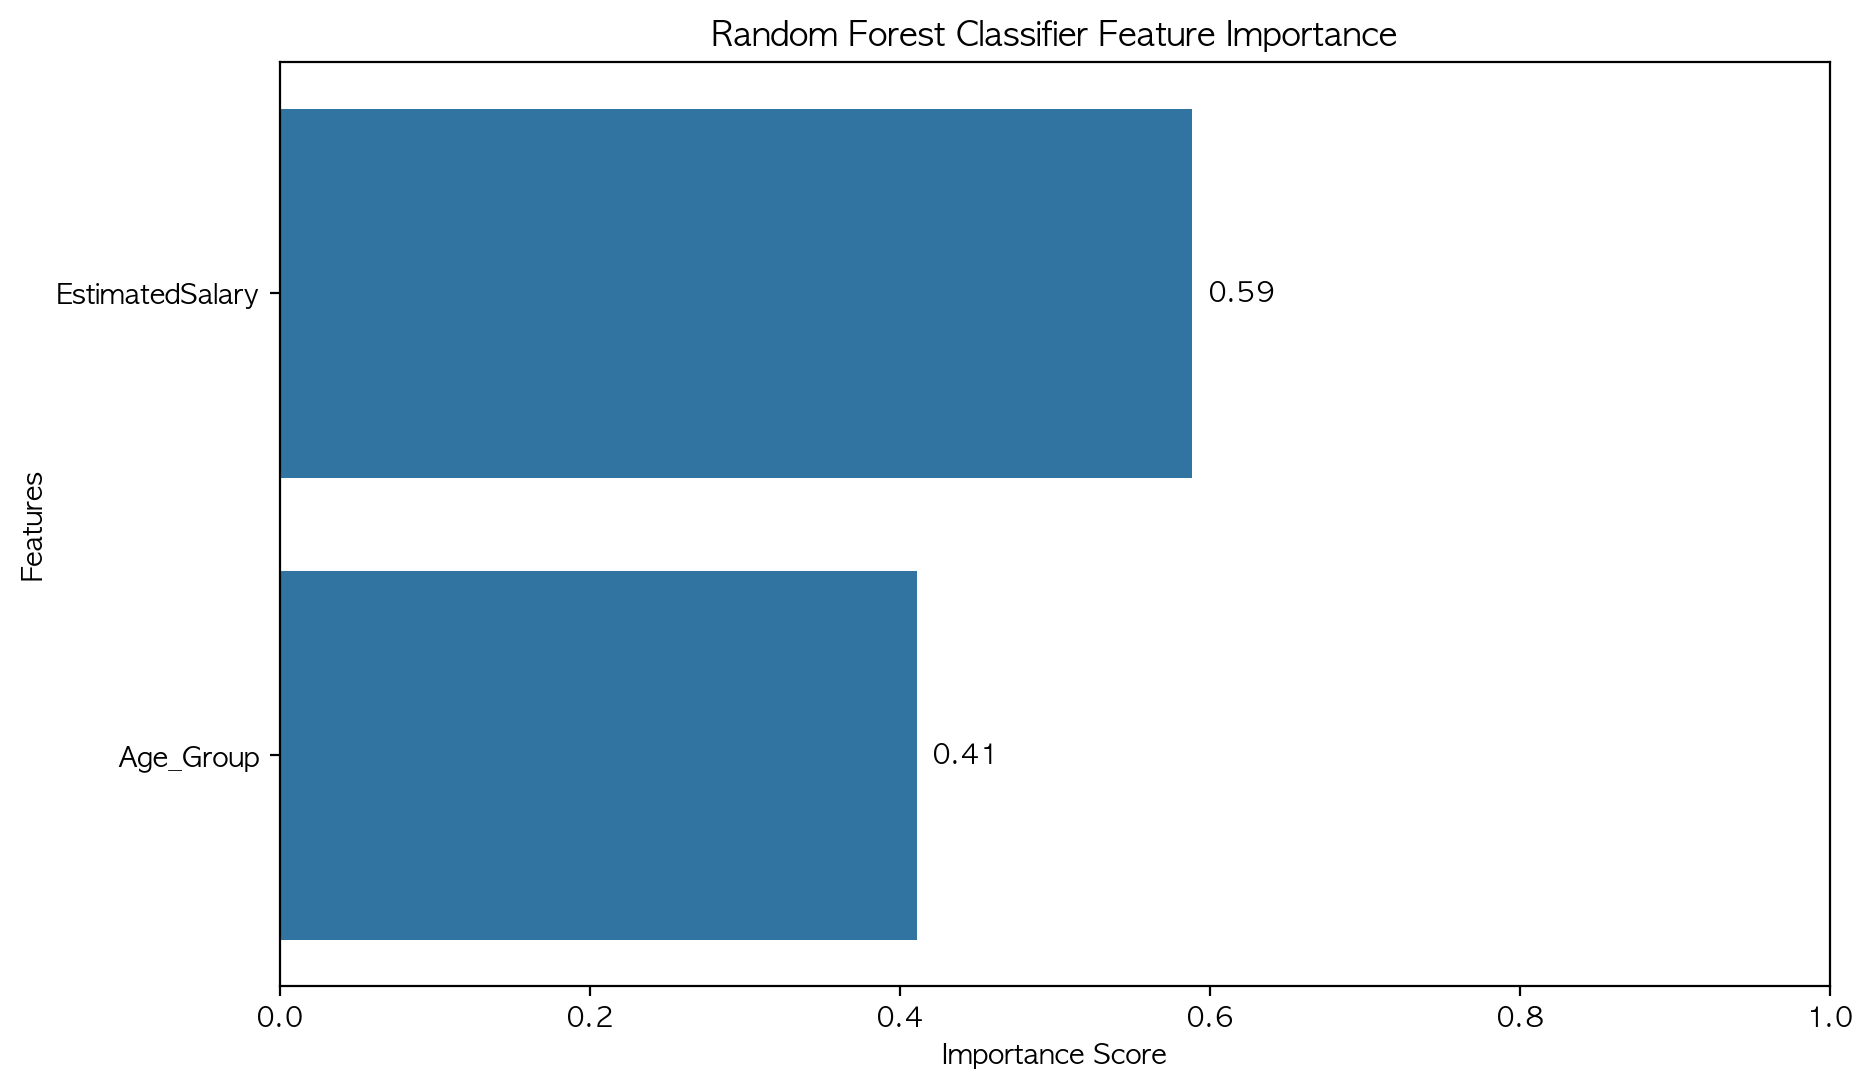

In [178]:
print(rfc.feature_importances_)
vis_feature_importance(rfc.feature_importances_, 'Random Forest Classifier')

### ROC / ACU

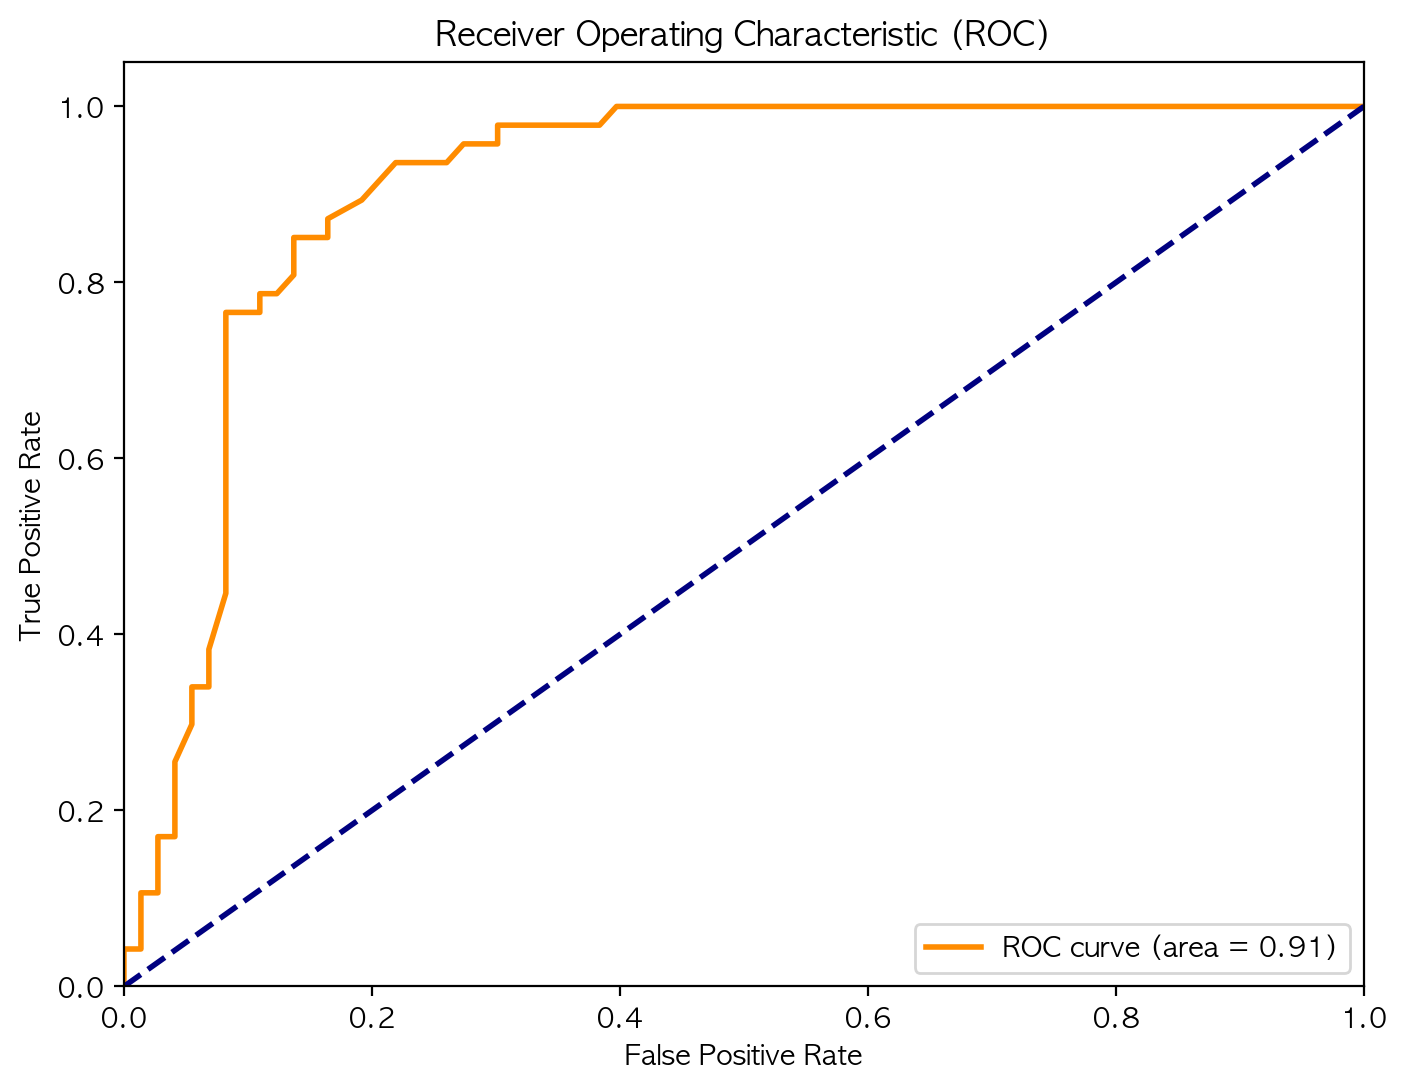

In [179]:
# 예측 확률 계산
y_prob = rfc.predict_proba(X_test)[:, 1]

# ROC 곡선 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# ROC 곡선 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### Precision-Recall Curve

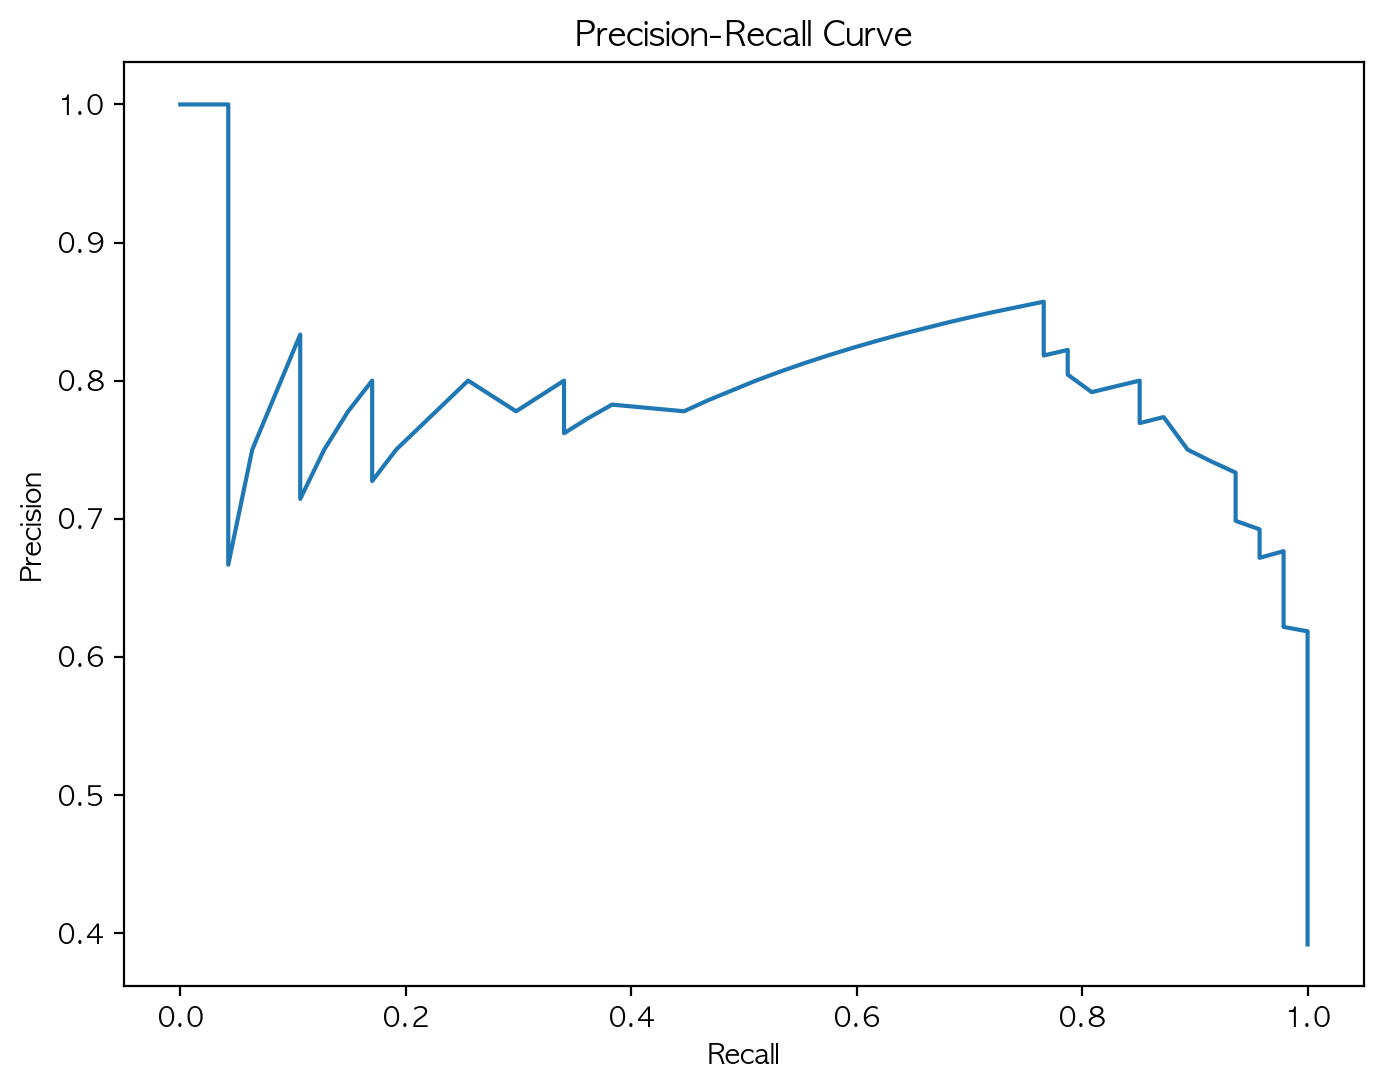

In [180]:
# 정밀도, 재현율, 임계값 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)

# Precision-Recall Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

### GridSearch

In [181]:
# parameters = {'max_depth': range(1,10), 'min_samples_split': range(2,10)}
# grid_rfc = GridSearchCV(rfc, param_grid=parameters, cv=3, refit=True, return_train_score=True)
# grid_rfc.fit(X_train, y_train)

# # GridSearchCV result
# scores_df = pd.DataFrame(grid_rfc.cv_results_)
# scores_df[['params', 'mean_test_score', 'rank_test_score']]

In [182]:
# # best params
# print(f'best params:', grid_rfc.best_params_)
# print(f'best score {grid_rfc.best_score_:.2%}')

## KNN

In [183]:
knn = KNeighborsClassifier(n_neighbors=5)

In [184]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [185]:
y_pred = knn.predict(X_test)

### confusion matrix

In [186]:
# vis_confusion_matrix(y_test,y_pred,"KNN")

### ROC Curve

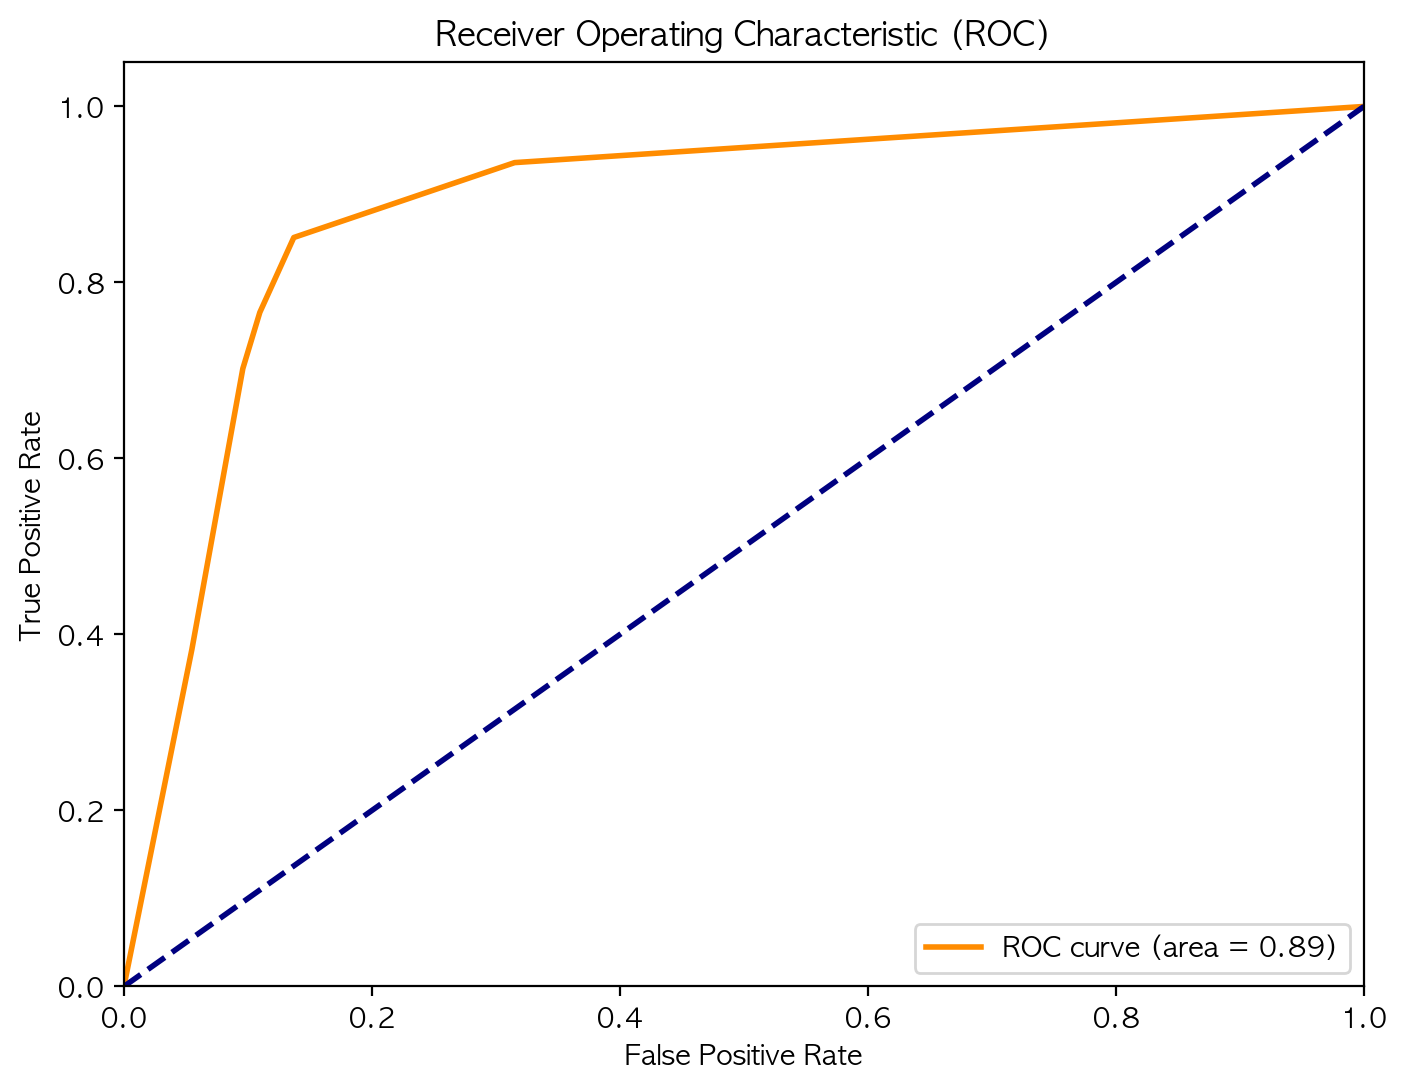

In [187]:
# 예측 확률 계산
y_prob = knn.predict_proba(X_test)[:, 1]

# ROC 곡선 및 AUC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# ROC 곡선 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### Precision-Recall Curve

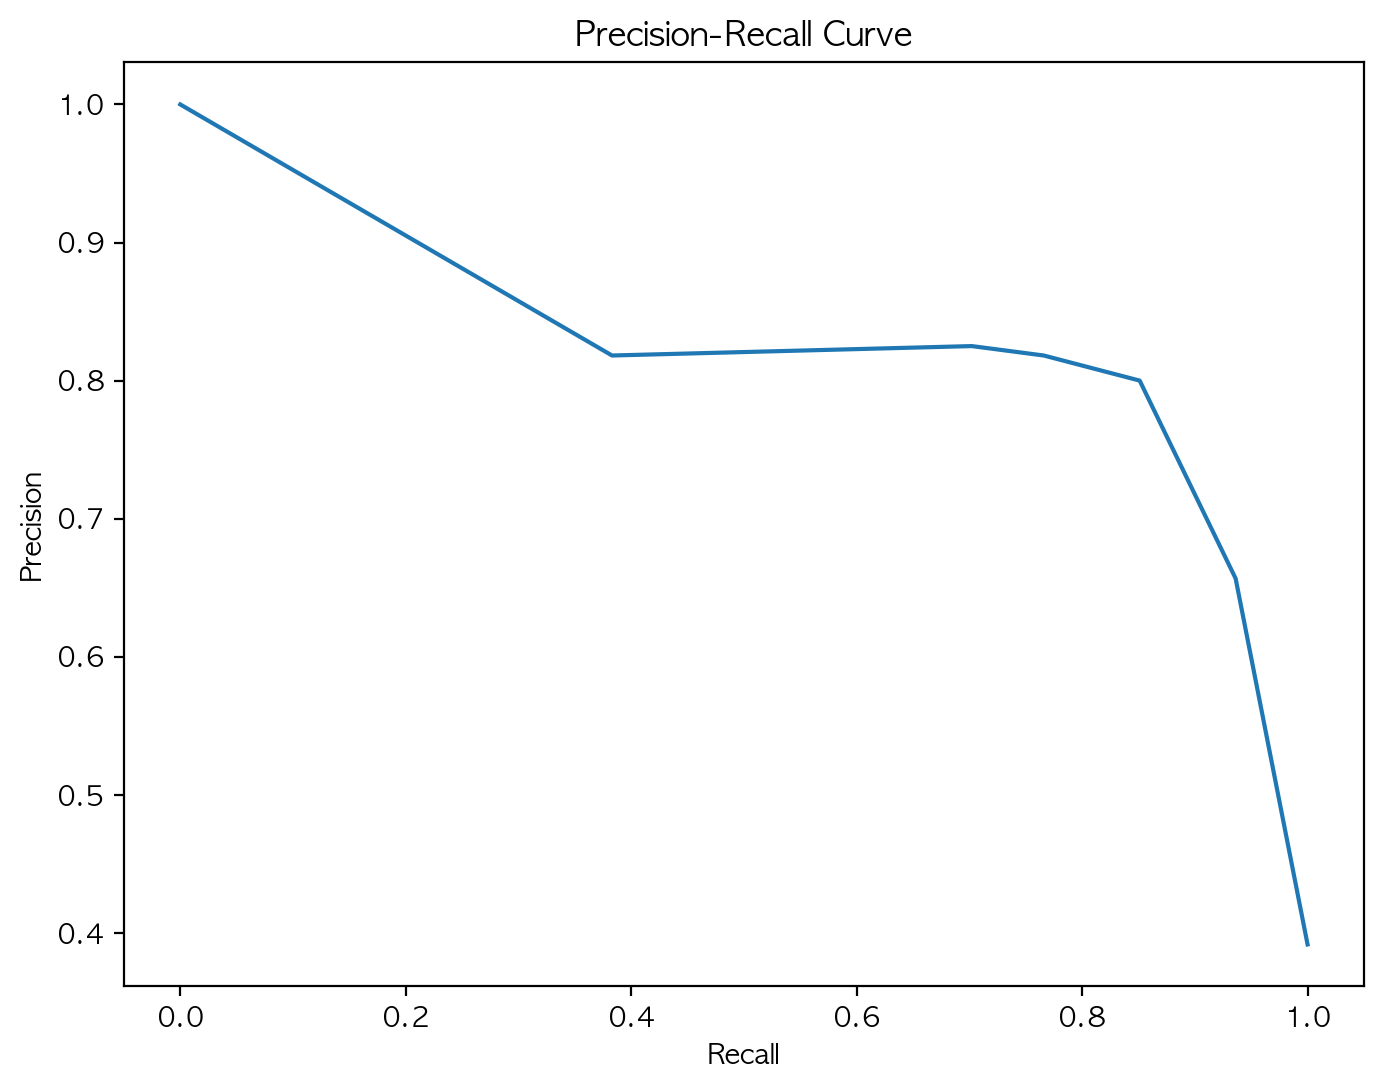

In [188]:
# 정밀도, 재현율, 임계값 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)

# Precision-Recall Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

### k-fold cross-validation

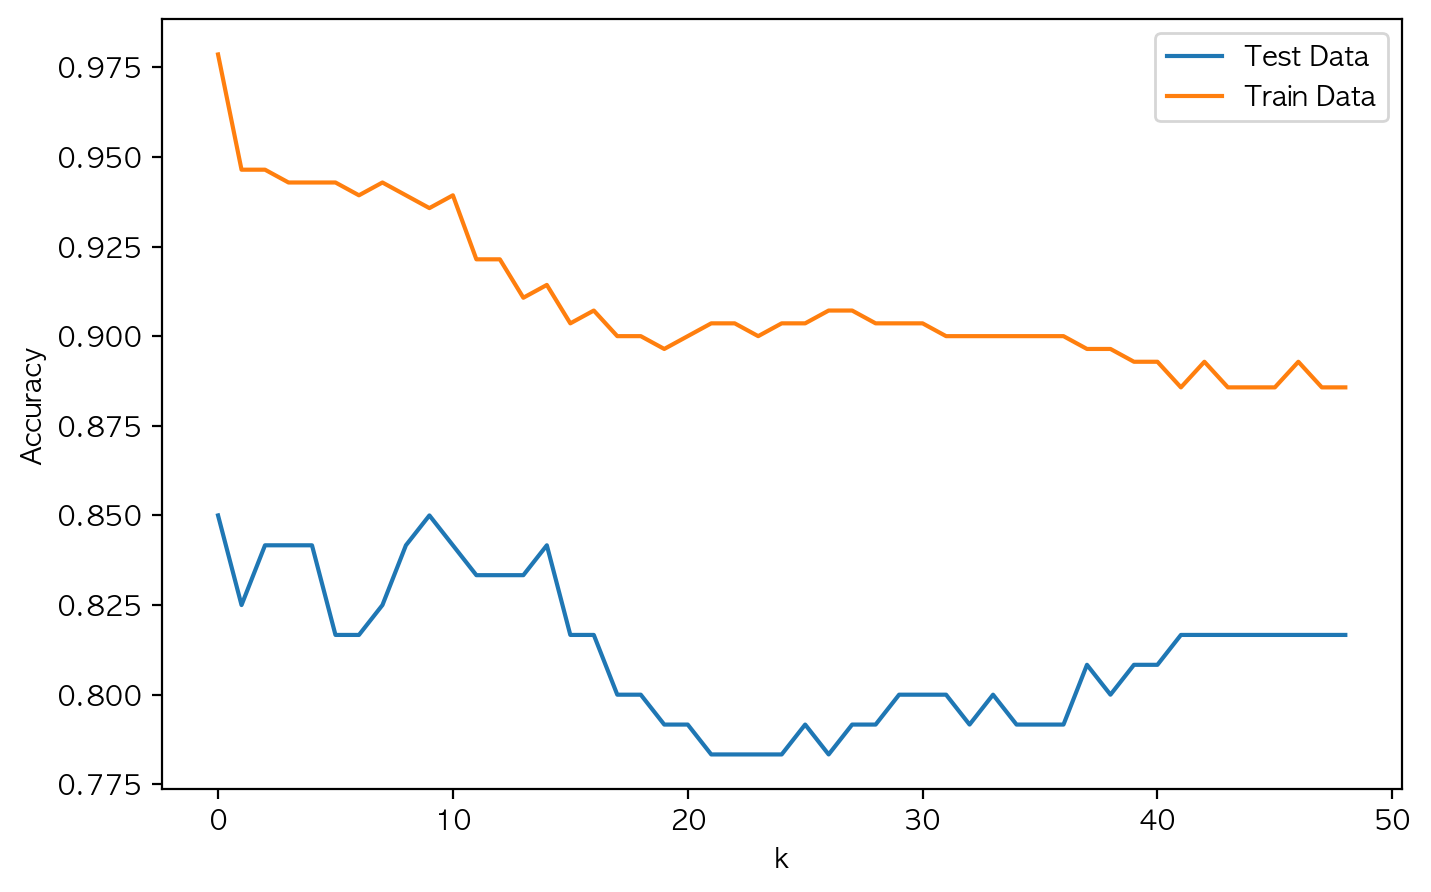

In [189]:
testAcc = []
trainAcc = []
cross_val_results = []
kf = KFold(n_splits=10, shuffle=True, random_state=12)
for k in range(1, 50): # k가 1부터 49까지
    # KNN 으로 Train 데이터 세트를 학습한다.
    knn = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
    knn.fit(X_train, y_train)
    
    # Test 세트의 Feature에 대한 정확도
    predY = knn.predict(X_test)
    testAcc.append((y_test == predY).sum() / len(predY))
    
    # Train 세트의 Feature에 대한 정확도
    predY = knn.predict(X_train)
    trainAcc.append((y_train == predY).sum() / len(predY))
    
    scores = cross_val_score(knn, X, y, cv=kf, scoring='accuracy')
    cross_val_results.append(scores.mean())
    
plt.figure(figsize=(8, 5))
plt.plot(testAcc, label="Test Data")
plt.plot(trainAcc, label="Train Data")
plt.legend()
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()

In [190]:
# 최적의 k값 찾기
optimal_k = range(1,50)[np.argmax(cross_val_results)]
optimal_k, max(cross_val_results)

(13, 0.9100000000000001)

## 머신 러닝 한번에 돌리기

In [191]:
# 학습용과 테스트용 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 모델 정의
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=12,max_depth=5,min_samples_split=7),
    'Random Forest': RandomForestClassifier(random_state=12,max_depth=5,min_samples_split=8),   
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

In [192]:
model_performance = {}

# 각 모델에 대해 학습 및 예측 수행
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # 성능 평가
    performance = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }
    model_performance[model_name] = performance

import pandas as pd
# 성능 결과를 데이터프레임으로 정리
performance_df = pd.DataFrame(model_performance).T
performance_df

,Accuracy,Precision,Recall,F1 Score
Decision Tree,0.925000,0.895833,0.914894,0.905263
Random Forest,0.941667,0.900000,0.957447,0.927835
KNN,0.925000,0.913043,0.893617,0.903226


#### 혼동행렬

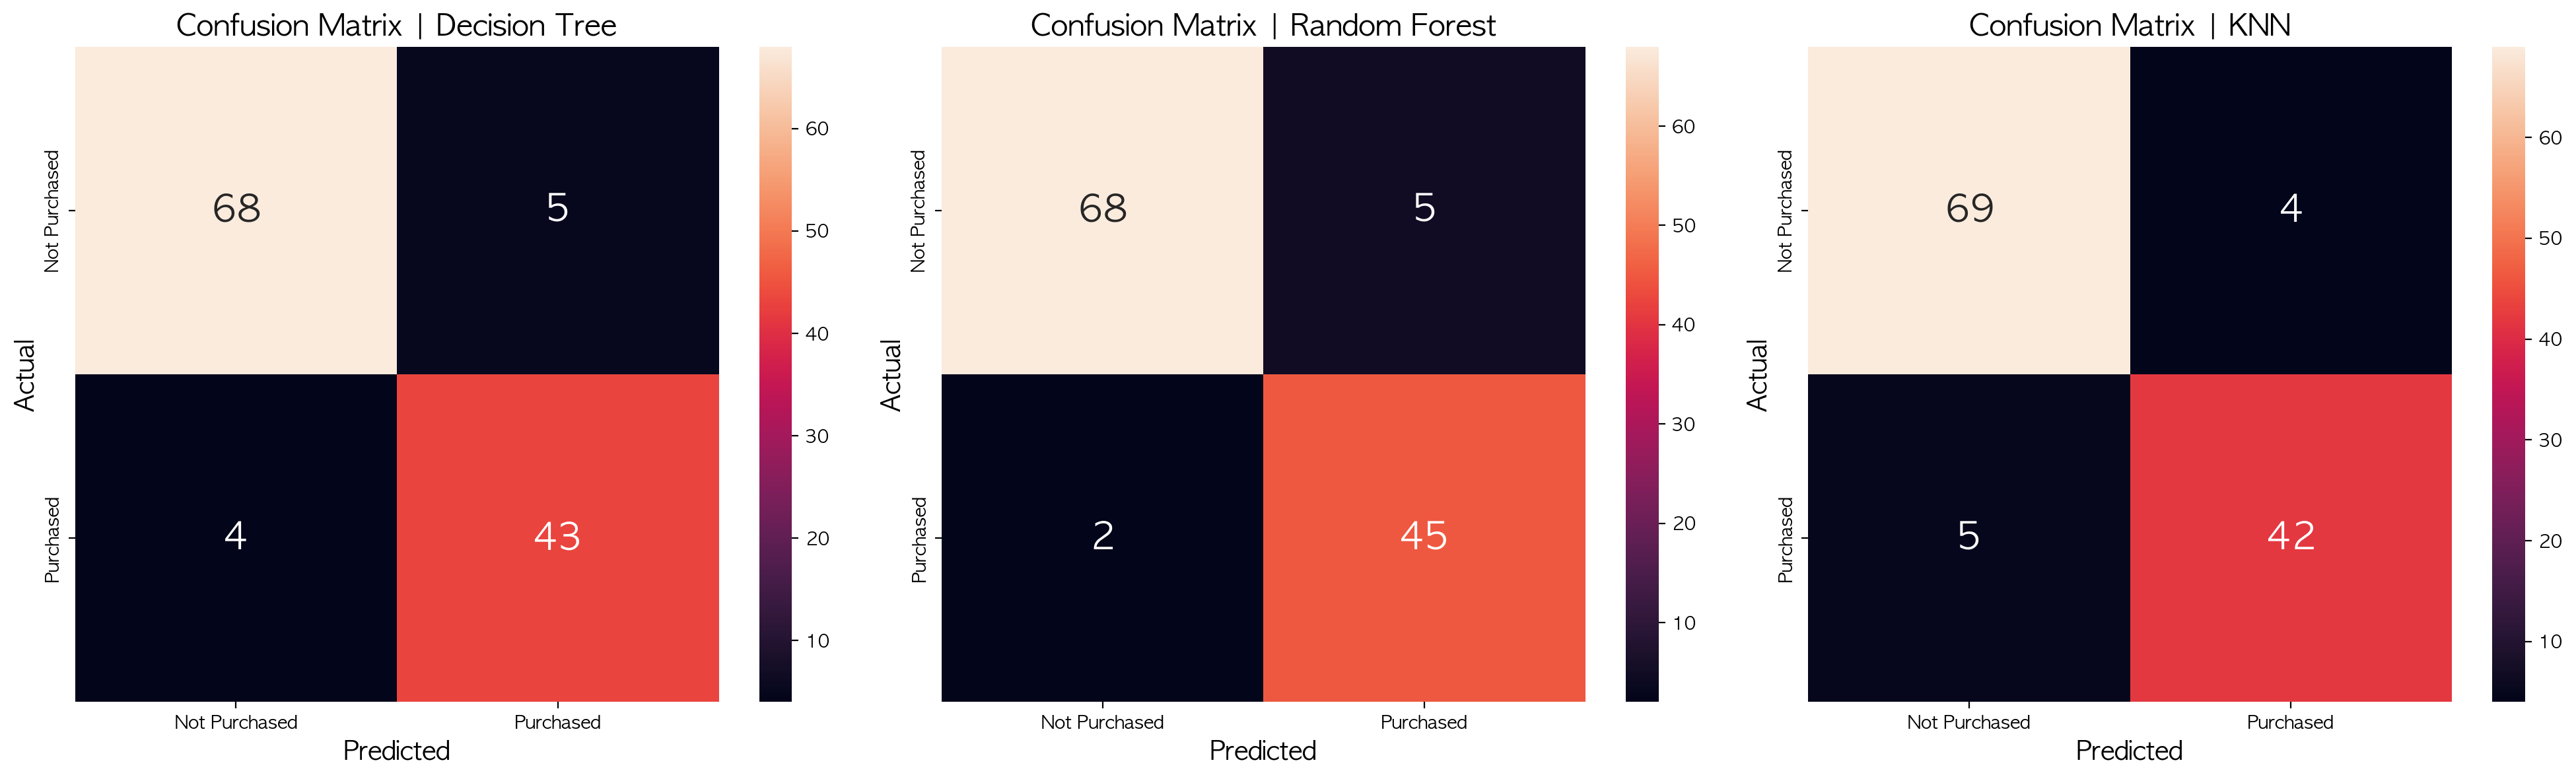

In [193]:
# 서브플롯 생성 (3개의 가로 축)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 각 모델에 대해 혼동 행렬 시각화
for ax, (model_name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test)
    vis_confusion_matrix(y_test, y_pred, model_name=model_name, ax=ax)
    
    # 글씨 크기 조정
    ax.title.set_size(16)  # 제목 글씨 크기
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)  # x축 레이블 크기
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)  # y축 레이블 크기
    
    # 혼동 행렬 내의 텍스트 크기 (만약 텍스트가 포함되어 있다면)
    for text in ax.texts:
        text.set_fontsize(20)  # 혼동 행렬 안의 텍스트 크기

plt.tight_layout()
plt.show()

#### 성능 (Accuracy, Precision, Recall, f1-score)

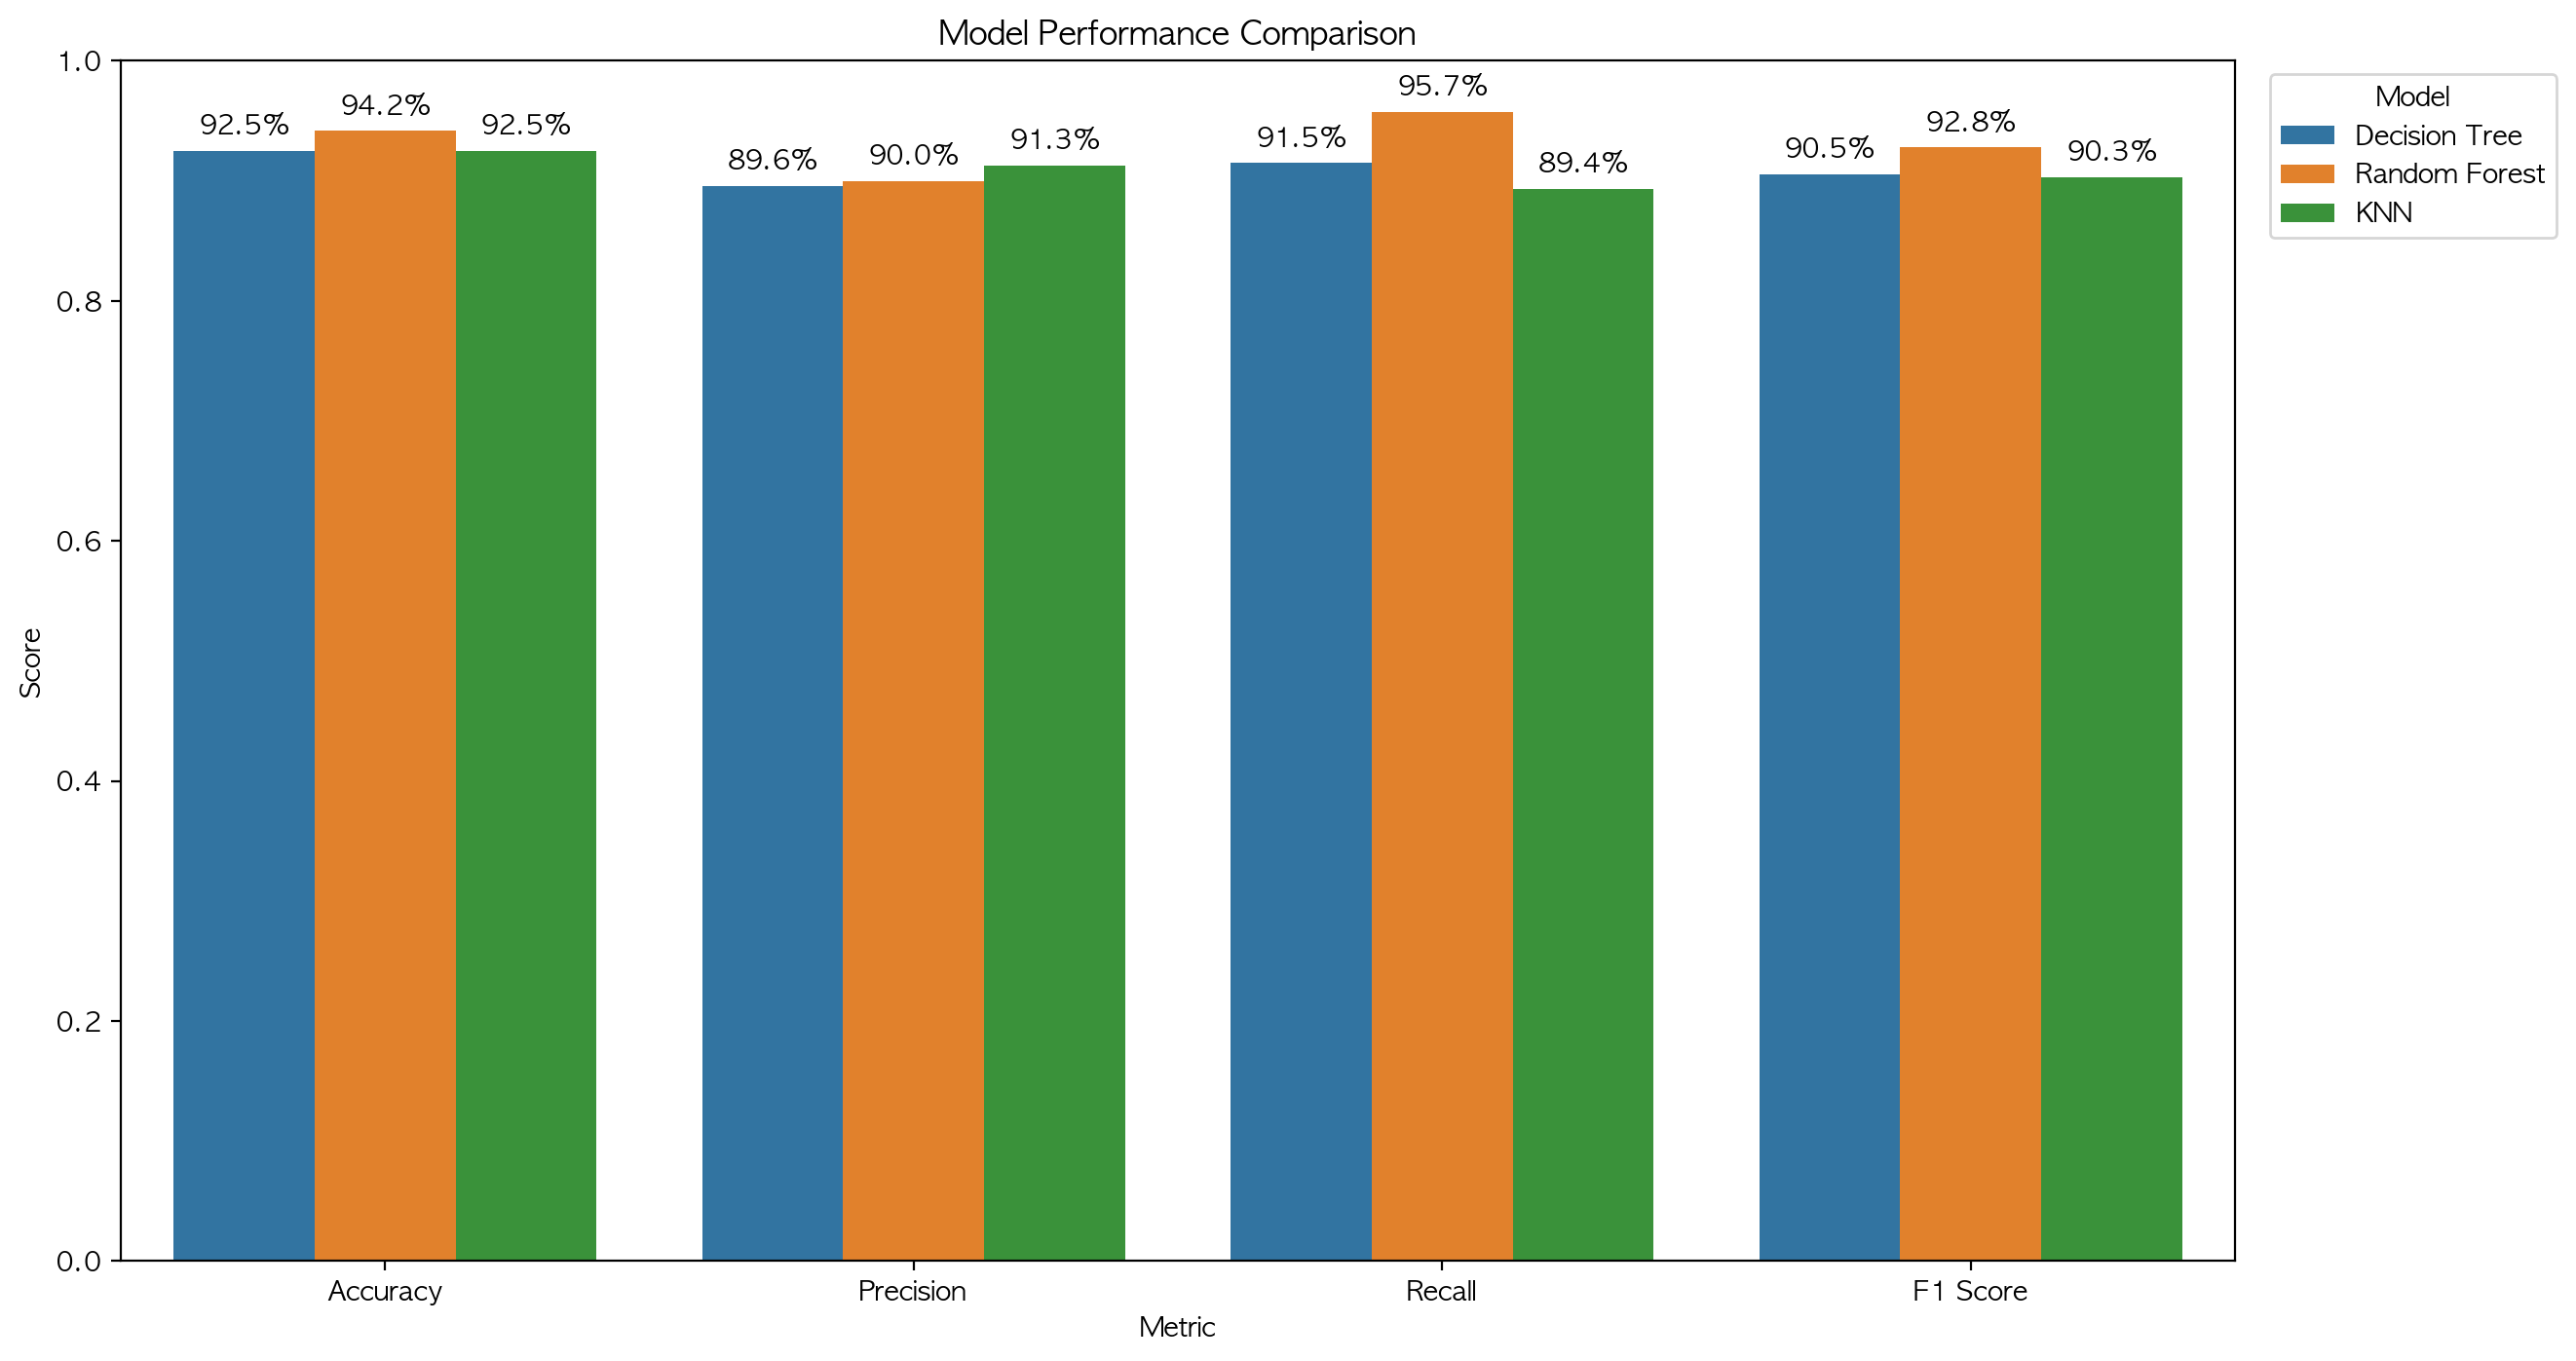

In [194]:

performance_df = performance_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 8))
sns.barplot(x='Metric', y='Score', hue='index', data=performance_df)

for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:
        plt.gca().annotate(f'{height*100:.1f}%', 
                           (p.get_x() + p.get_width() / 2., height), 
                           ha='center', va='center', 
                           xytext=(0, 9), textcoords='offset points')

plt.legend(title='Model', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.title('Model Performance Comparison')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

#### ROC Curve

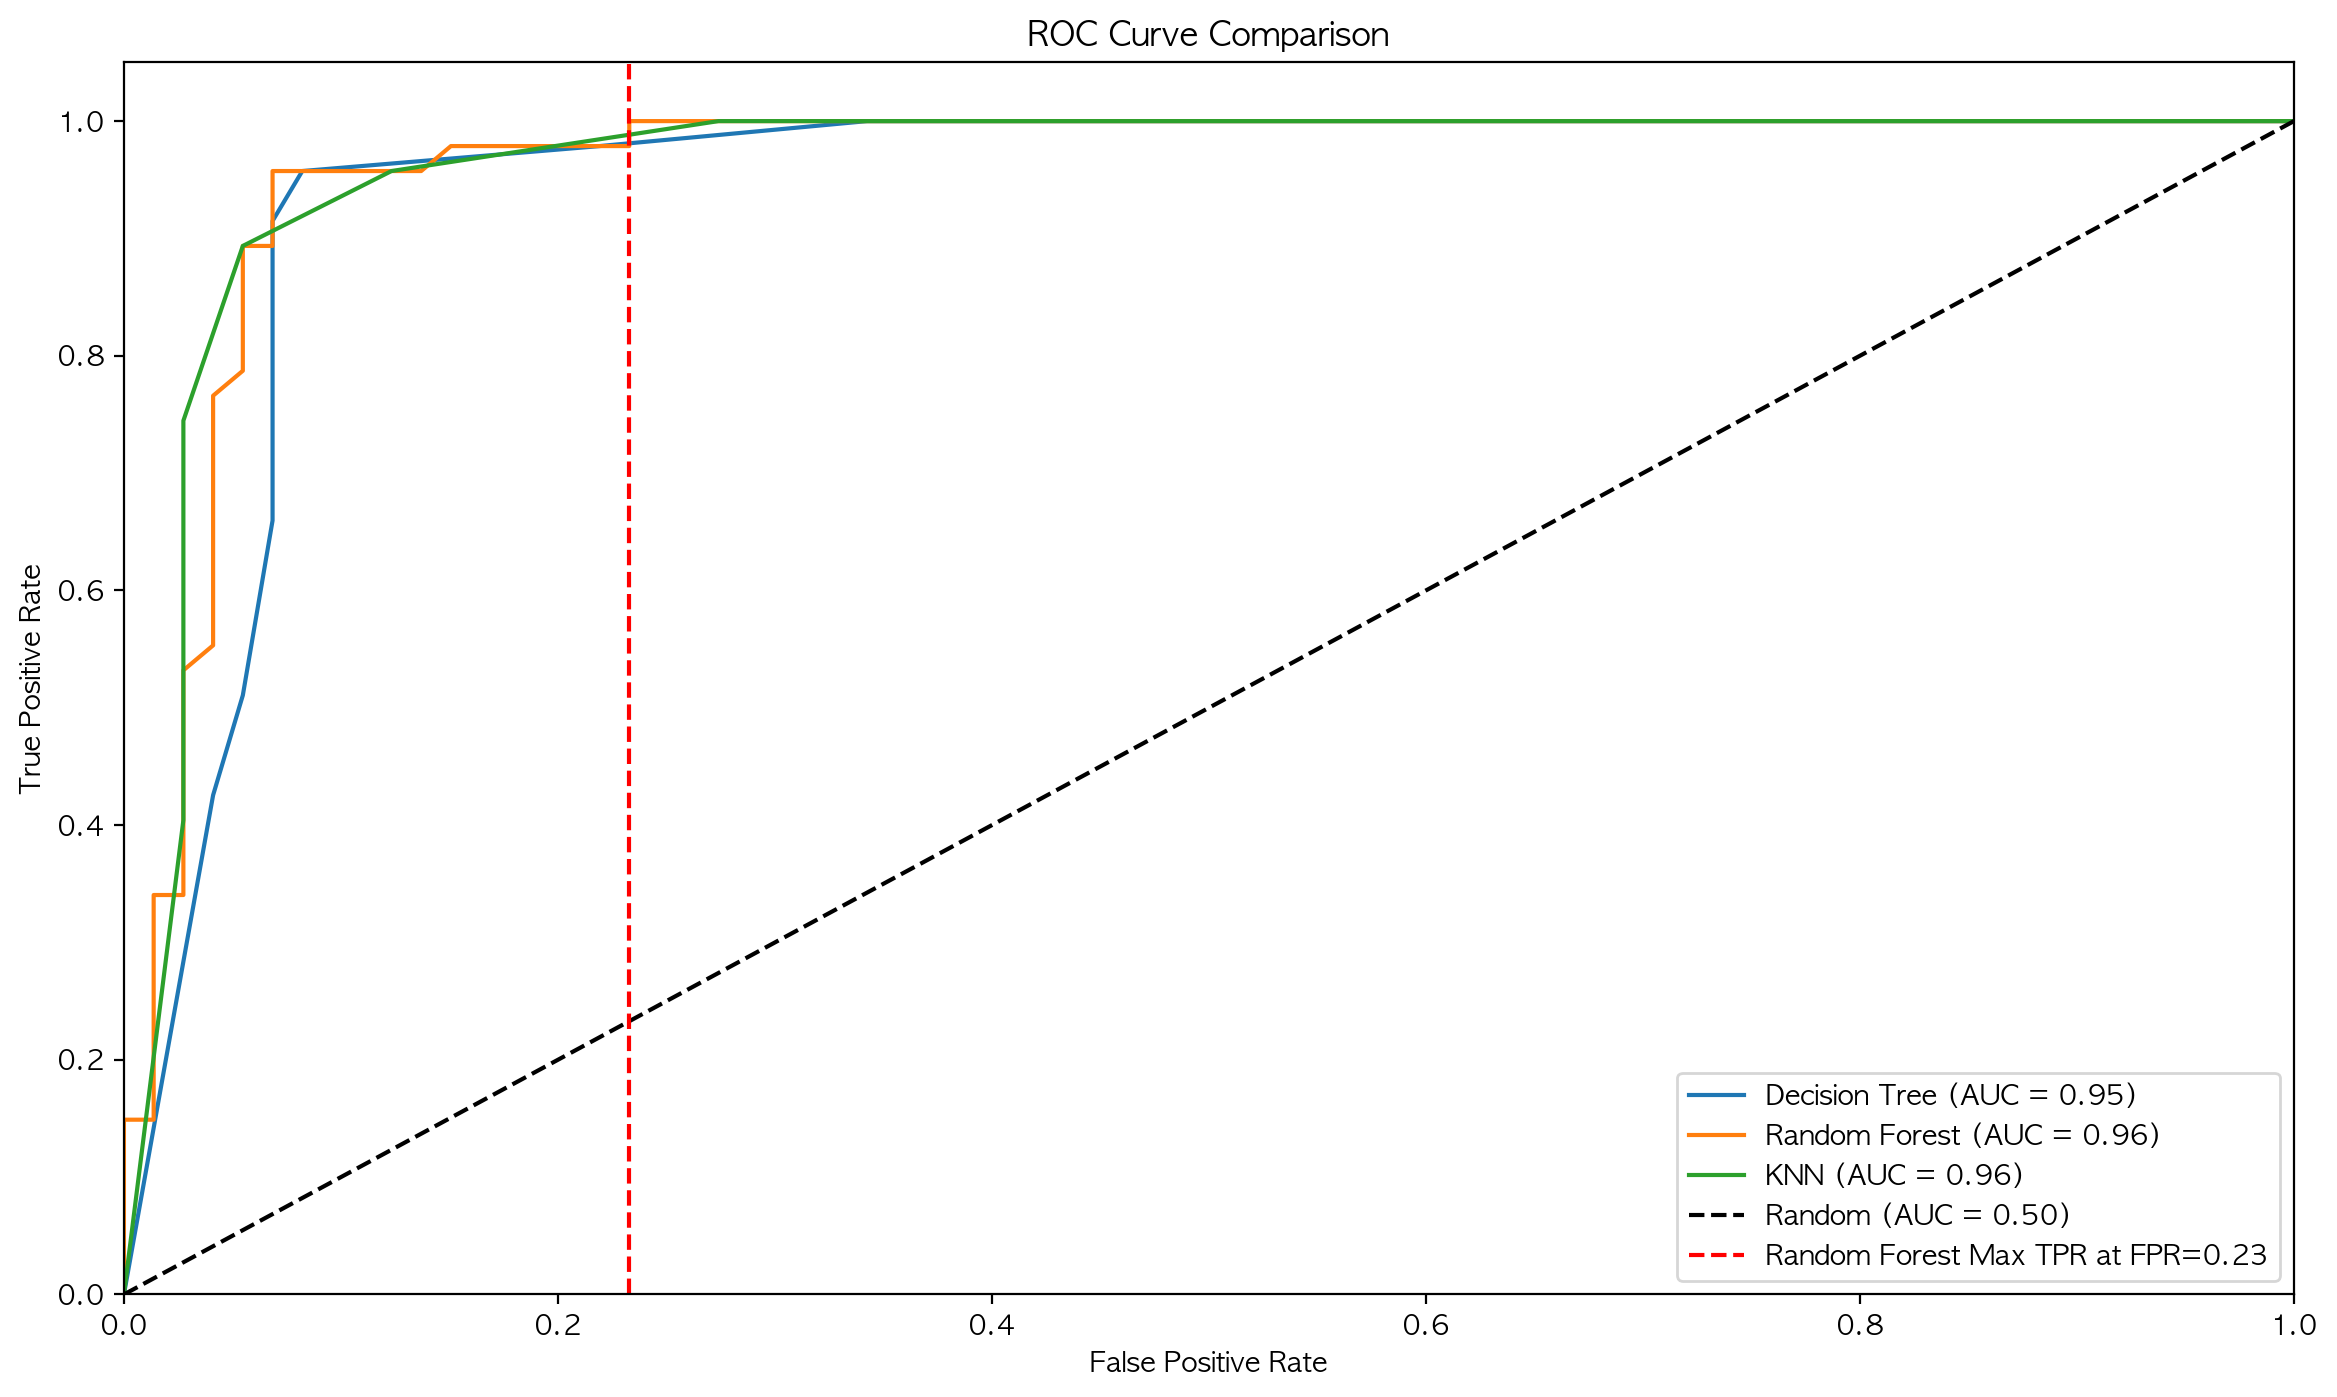

{'Decision Tree': 0.9481200816088603,
 'Random Forest': 0.9634217429320898,
 'KNN': 0.9648790440104926}

In [195]:
roc_auc = {}

plt.figure(figsize=(14, 8))

# 각 모델에 대해 ROC 곡선과 AUC 계산 및 시각화
for model_name, model in models.items():
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc[model_name] = auc(fpr, tpr)
    
    # Random Forest의 최고 TPR을 기준으로 수직선을 긋기 위한 조건
    if model_name == 'Random Forest':
        max_tpr_rf_idx = tpr.argmax()
        max_tpr_rf_fpr = fpr[max_tpr_rf_idx]
    
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc[model_name]:.2f})')

# 무작위 분류자 기준선 (AUC=0.5)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

# Random Forest 최고점에서의 수직선 그리기
plt.axvline(x=max_tpr_rf_fpr, color='red', linestyle='--', label=f'Random Forest Max TPR at FPR={max_tpr_rf_fpr:.2f}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

roc_auc

#### 러닝커브

In [196]:
# Function to plot learning curves
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5), ax=None):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.set_title(title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

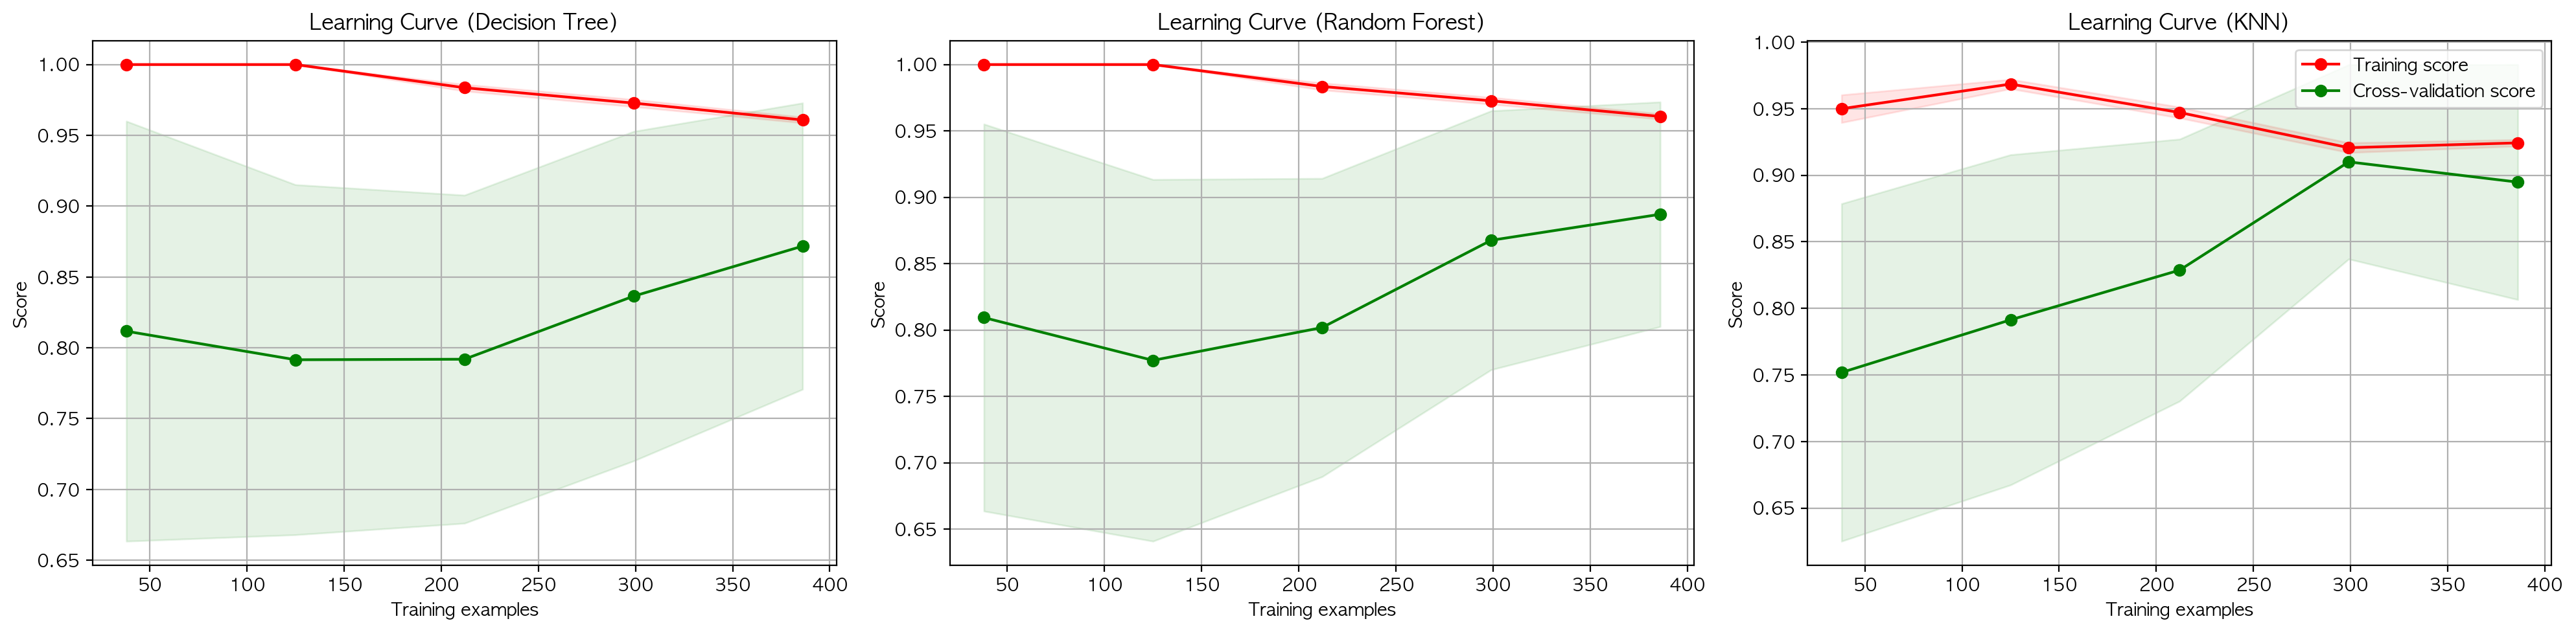

In [197]:
# Replace X and y with your features and target variables
cv = StratifiedKFold(n_splits=30)

# Prepare the figure and axes for the plots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plotting learning curves for each model
plot_learning_curve(DecisionTreeClassifier(), "Learning Curve (Decision Tree)", X, y, cv=cv, ax=axes[0])
plot_learning_curve(RandomForestClassifier(), "Learning Curve (Random Forest)", X, y, cv=cv, ax=axes[1])
plot_learning_curve(KNeighborsClassifier(), "Learning Curve (KNN)", X, y, cv=cv, ax=axes[2])

# Add legend only to the last subplot to avoid clutter
axes[2].legend(loc="best")

plt.tight_layout()
plt.show()

## 모델 선택 후(Random Forest Classifier)

### 교차검증

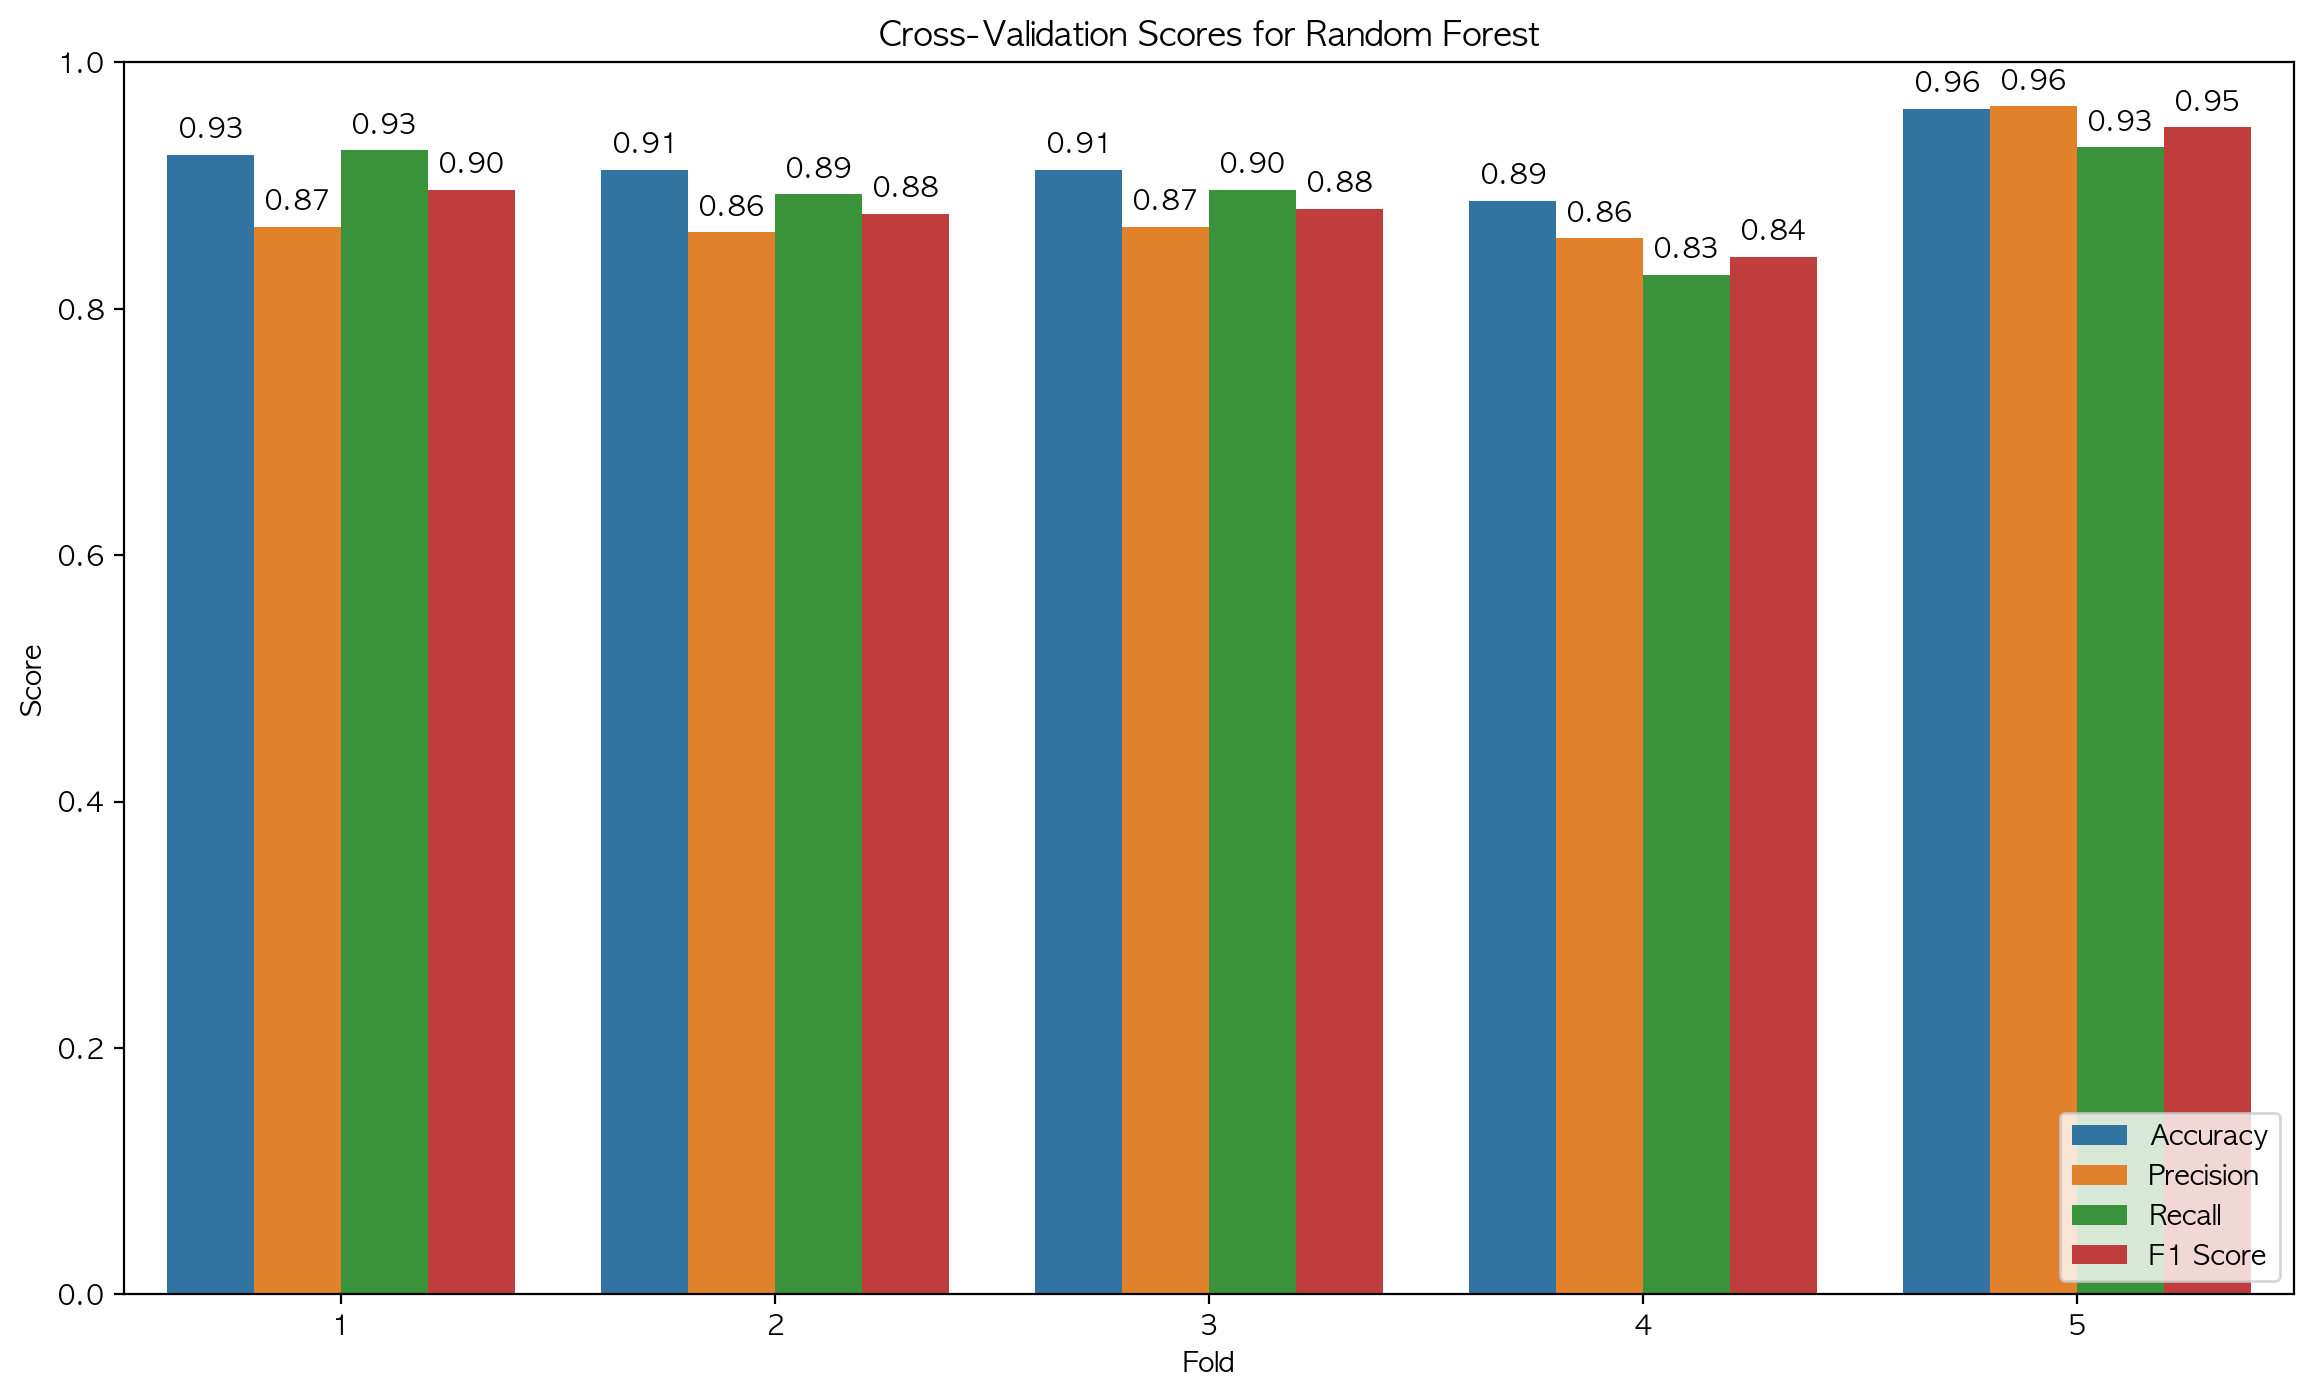

In [198]:
# Random Forest 모델
rf_model = models['Random Forest']

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

# 교차 검증 수행
# 교차 검증 수행
accuracy_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='accuracy')
precision_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='precision')
recall_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='recall')
f1_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='f1')

# 교차 검증 결과를 DataFrame으로 정리
cv_results = pd.DataFrame({
    'Fold': range(1, len(accuracy_scores) + 1),
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
})

# 교차 검증 결과 시각화
plt.figure(figsize=(14, 8))
cv_results_melted = cv_results.melt(id_vars='Fold', var_name='Metric', value_name='Score')
sns.barplot(x='Fold', y='Score', hue='Metric', data=cv_results_melted)

# 각 막대 위에 수치 표시
for p in plt.gca().patches:
    height = p.get_height()
    # Check if the height is greater than 0 to annotate
    if height > 0:
        plt.gca().annotate(f'{p.get_height():.2f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 9), textcoords='offset points')
        

plt.title('Cross-Validation Scores for Random Forest')
plt.ylabel('Score')
plt.xlabel('Fold')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

In [199]:
# 각 Metric의 평균값에 대한 가로선 추가
mean_scores = cv_results.mean()
mean_scores

Fold         3.000000
Accuracy     0.920000
Precision    0.883366
Recall       0.895320
F1 Score     0.888915
dtype: float64

### feature importance

[0.63785188 0.36214812]


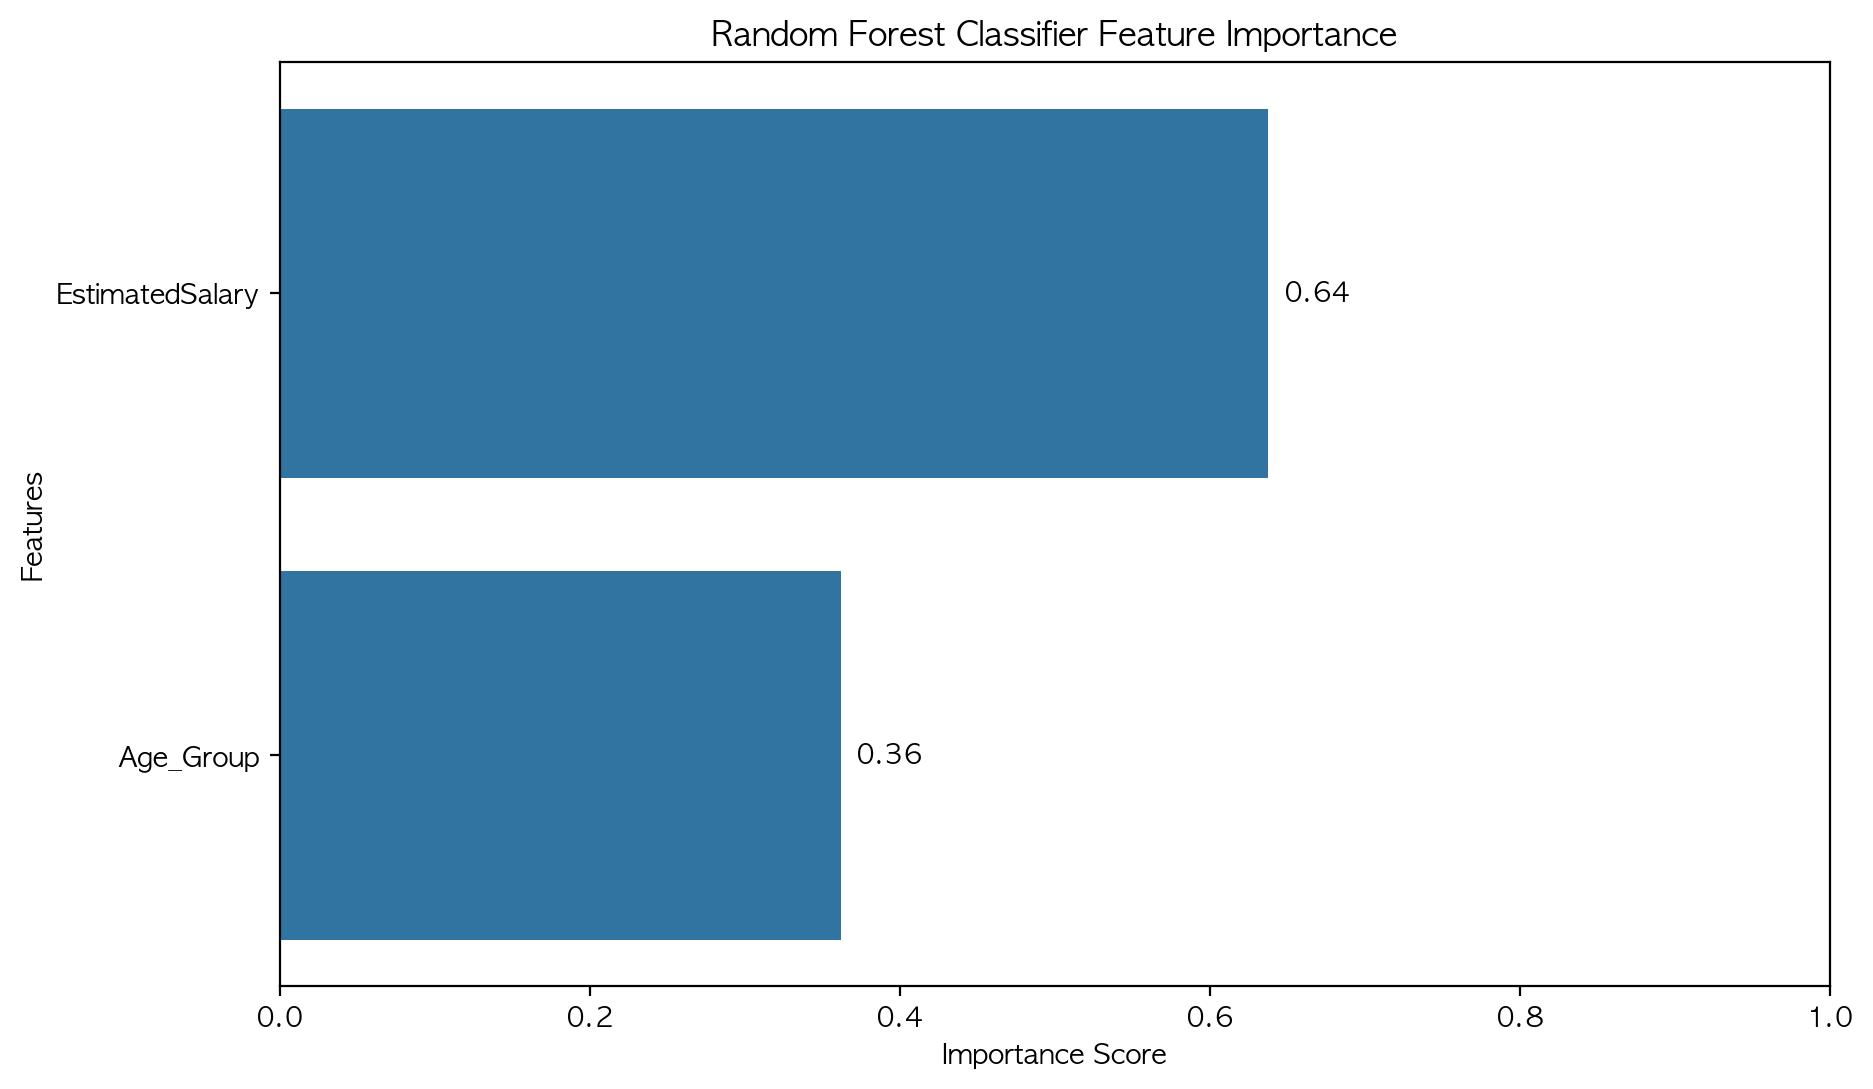

In [200]:
print(rf_model.feature_importances_)
vis_feature_importance(rf_model.feature_importances_, 'Random Forest Classifier')

## Result


### Discussion